##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [2]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

%matplotlib notebook

# %matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass



from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD','fco2':'fco2',
        'Out_of_Basin':'Upland','Upland':'Upland',#'F$_{up}$',
        'Sedge':'Sedge','Shrub':'Shrub',#'F$_{shb}$',
        'Sparse':'Sparse','Grass':'Grass',#'F$_{grs}$',
        'HR':'Hour','DOY':'DOY',
        'NR_Wm2_Avg':'NR_Wm2_Avg','Temp':'T$_{s}$','H':'$H$','VPD':'VPD','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'AirTC_Avg':'T$_{a}$','air_pressure':'P$_{a}$',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$','(z-d)/L':'Stability'}

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
Site='Illisarvik'

C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dt

In [3]:
class ResultMap:
    def __init__(self,target,Test='SE',Rule=1,alpha = .025,AltPath=None):
        self.Rule = Rule
        self.target = target        
        self.params = Dense.Params('Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += self.target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Records['SE']
        Names = []
        rem = []
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Records['T2']=0
        self.Records['Select'] = 0
        for j in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==j]
            if j == 1:
                self.level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
            else:
                try:
                    self.level_best = self.level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                except:
                    self.level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                    pass
            ##T-test
            if Test == 'T':
                Sv = (((Level['SE']**2+self.Min['SE'].values[0]**2)/2)**.5)
                Level['T2']=(Level['MSE']-self.Min['MSE'].values[0])/(Sv*(2/self.params['K'])**.5)

                Level.loc[Level['T2'].abs()<=stats.t.ppf(1-alpha,self.params['K']),'Select']+=1
            ##SE-Rule
            if Test == 'RMSE':
                Level.loc[Level['RMSE']<=self.Min['RMSE'].values[0]+.1,'Select']+=1
            elif Test == 'SE':
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+self.Min['SE'].values[0]*Rule,'Select']+=1
            elif Test == 'PCT':
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0]+Rule,'Select']+=1
            elif Test == 'Thresh':
                self.Min = self.Records.loc[self.Records['Thresh']==self.Records['Thresh'].min()]
                Level.loc[Level['Thresh']<=self.Min['Thresh'].values[0],'Select']+=1
            else:
                self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
                Level.loc[Level['MSE']<=self.Min['MSE'].values[0],'Select']+=1
            self.Records.loc[self.Records['Size']==j]=Level
        Trecords = self.Records.loc[self.Records['Select']==self.Records['Select'].max()]
        self.Best = Trecords.loc[Trecords['Size']==Trecords['Size'].min()]
        if Test == 'Thresh':
            self.Best = self.Best.loc[self.Best['Thresh']==self.Best['Thresh'].min()]
        else:
            self.Best = self.Best.loc[self.Best['MSE']==self.Best['MSE'].min()]
            
        self.Model_Selection = self.Best.loc[self.Best['MSE'] == self.Best['MSE'].min(), 'Model'].values[0]
            
#         for level in self.Records['Size'].unique():
#             Level = self.Records.loc[self.Records['Size']==level]

                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
#         print()
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
#         prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
#         display(prog1)
        print(self.params['K'])
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.params['K']))):
#                 prog1.value+=1
                Y = results[0]
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        YVar = Dense.Load_Model(i=0,X=X,params=self.params)[0]
        YVar = self.RST.YvarScaled.inverse_transform(YVar) 
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(0,1))):
            YVar = results[0]
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                   
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     

In [4]:
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
#         print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        print(i,Labs)
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
#         print(labels)
    print(target.level_best['Size'],labels)
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<IPython.core.display.Javascript object>


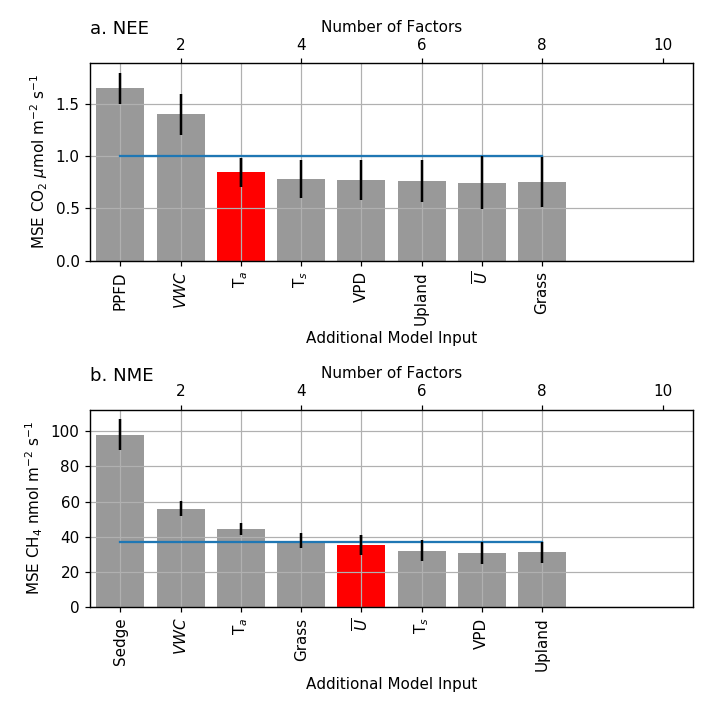

1 ['PPFD_Avg']
2 ['PPFD_Avg', 'VWC']
3 ['PPFD_Avg', 'VWC', 'AirTC_Avg']
4 ['PPFD_Avg', 'VWC', 'AirTC_Avg', 'Temp']
5 ['PPFD_Avg', 'VWC', 'AirTC_Avg', 'Temp', 'VPD']
6 ['PPFD_Avg', 'VWC', 'AirTC_Avg', 'Temp', 'VPD', 'Out_of_Basin']
7 ['PPFD_Avg', 'VWC', 'AirTC_Avg', 'Temp', 'VPD', 'Out_of_Basin', 'wind_speed']
8 ['PPFD_Avg', 'VWC', 'AirTC_Avg', 'Temp', 'VPD', 'Out_of_Basin', 'wind_speed', 'Grass']
0     1
5     2
10    3
20    4
25    5
35    6
36    7
42    8
Name: Size, dtype: int64 ['PPFD', '$VWC$', 'T$_{a}$', 'T$_{s}$', 'VPD', 'Upland', '$\\overline{U}$', 'Grass']
1 ['Sedge']
2 ['Sedge', 'VWC']
3 ['Sedge', 'VWC', 'AirTC_Avg']
4 ['Sedge', 'VWC', 'AirTC_Avg', 'Grass']
5 ['Sedge', 'VWC', 'AirTC_Avg', 'Grass', 'wind_speed']
6 ['Sedge', 'VWC', 'AirTC_Avg', 'Grass', 'wind_speed', 'Temp']
7 ['Sedge', 'VWC', 'AirTC_Avg', 'Grass', 'wind_speed', 'Temp', 'VPD']
8 ['Sedge', 'VWC', 'AirTC_Avg', 'Grass', 'wind_speed', 'Temp', 'VPD', 'Out_of_Basin']
0     1
1     2
3     3
15    4
19    5
25    6


In [12]:

fco2 = ResultMap('fco2',Test='SE',Rule=1)
fch4 = ResultMap('fch4',Test='SE',Rule=1)
# ER = ResultMap('ER',Test='SE',Rule = 1,AltPath='ER')
ER_interp = ResultMap('ER',Test='SE',Rule=1,AltPath='fco2')
# # # ER_0 = ResultMap('ER',Test='SE',Rule=1,AltPath='ER_0')
# # # ER_10 = ResultMap('ER',Test='SE',Rule=1,AltPath='ER_10')
# # # Temp_0 = ResultMap('ER',Test='SE',Rule=1,AltPath='Temp_0')
# # # Temp_10 = ResultMap('ER',Test='SE',Rule=1,AltPath='Temp_10')
fco2_fixed = ResultMap('fco2',Test='SE',Rule=1)
fch4_fixed = ResultMap('fch4',Test='SE',Rule=1)
ER_fixed = ResultMap('ER',Test='SE',Rule=1,AltPath='fco2')

fig,ax=plt.subplots(2,1,figsize=(6.5,6.5))
# ax[0].set_xlim(0.5,9.5)
# ax[1].set_xlim(0.5,9.5)
Performance(ax[0],'a. NEE',fco2,verbose = 0,lim=[0.5,10.5])#,extra=9)
# Performance(ax[1],'b. ER',ER,verbose = 0)
Performance(ax[1],'b. NME',fch4,verbose = 0,lim=[0.5,10.5])
ax[0].set_ylabel('MSE CO$_{2}$ ${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[1].set_ylabel('MSE CH$_{4}$ nmol m$^{-2}$ s$^{-1}$')
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/FigA1.png',dpi=300)
print(fch4.level_best)

<IPython.core.display.Javascript object>


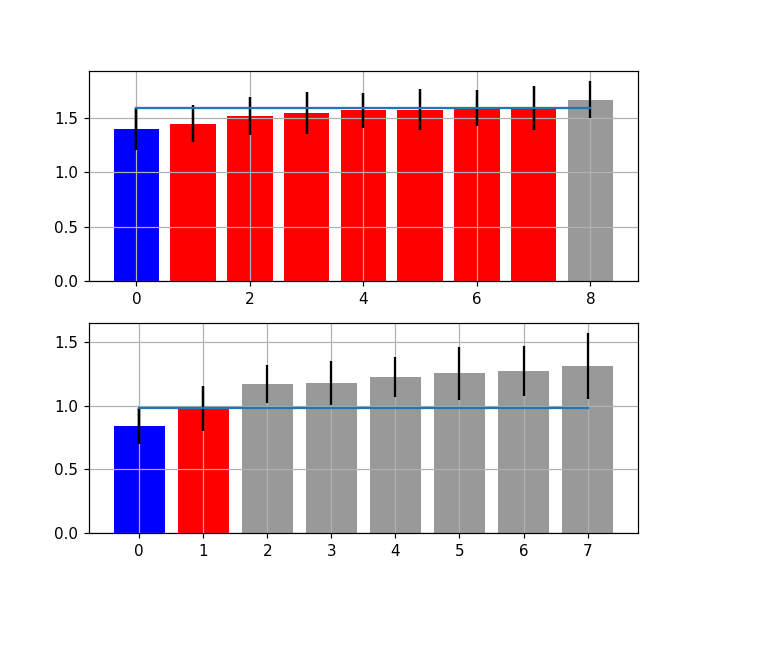

   index                  Model       MSE  Size  Number  HiddenNodes  \
0      5           PPFD_Avg+VWC  1.400460     2       4          152   
1      2           PPFD_Avg+VPD  1.450176     2       1          152   
2      1     PPFD_Avg+AirTC_Avg  1.520757     2       0          152   
3      3    PPFD_Avg+wind_speed  1.548970     2       2          152   
4      9  PPFD_Avg+Out_of_Basin  1.572669     2       8          152   
5      4          PPFD_Avg+Temp  1.580081     2       3          152   
6      6         PPFD_Avg+Sedge  1.593176     2       5          152   
7      7         PPFD_Avg+Shrub  1.595181     2       6          152   
8      8         PPFD_Avg+Grass  1.671576     2       7          152   

         SE        r2  Performance   K    Thresh Model_Key      RMSE  T2  \
0  0.196584  0.873973            1  10  1.597045       2_4  1.183410   0   
1  0.167576  0.869499            0  10  1.617751       2_1  1.204232   0   
2  0.172877  0.863147            0  10  1.693634   

In [13]:
fig,ax=plt.subplots(2,1,figsize=(6.5,5.5))
LevelPerformance(ax[0],'a. fco2',fco2,level=2)
LevelPerformance(ax[1],'b. fch4',fco2,level=3)
# # # print(ER.Model)
# # # print(ER_0.Model)
# # # print(ER_10.Model)
# # # print(ER_interp.Model)
# # # plt.figure()
# # # plt.scatter(T30['ER_est'],T30['AirTC_Avg'])
# # # plt.figure()
# # # plt.scatter(T30['ER_est'],T30['VPD'])
# # # print(fco2.Model_Selection)
# # # ER.Model_Selection='PPFD_Avg+VPD+VWC'
# # print(fco2.Best)
# print(fch4.level_best
#      )
# # print(ER.Best)
# # print(T30.loc[T30.ER.isin(T30.nsmallest(5000,'ER')['ER'].values)==False])

In [14]:
T30 = fco2.RST.Master.copy()

T30['VWC'].loc[T30['VWC']<.5]=np.nan
T30['VWC']=T30['VWC'].interpolate()

T30['Rain_mm_Tot']=T30['Rain_mm_Tot'].fillna(0)*10
T30[['Sedge','Shrub','Grass','Upland']]=T30[['Sedge','Shrub','Grass','Upland']].interpolate()

T30_Dark = T30.copy()
T30_Fixed = T30.copy()
T30_Dark['PPFD_Avg']=T30['PPFD_Avg'].min()
print(T30['PPFD_Avg'].min())
# T30 = T30BU.copy()
FPRatios = {'Sedge':0.122590,
            'Sparse':0.083902,
            'Shrub':0.482874,
            'Grass':0.279263,
            'Upland':0.0,
            'Out_of_Basin':0.0
}
# FPRatios = {'Sedge':0,
#             'Sparse':.0,
#             'Shrub':1,
#             'Grass':.0,
#             'Upland':0.0,
#             'Out_of_Basin':0
# }
# T30 = T30BU.copy()
for var in ['Sedge','Sparse','Shrub','Grass','Upland','Out_of_Basin']:
    T30_Fixed[var] = FPRatios[var]
T30_Dark_Fixed = T30_Fixed.copy()
T30_Dark_Fixed['PPFD_Avg']=T30['PPFD_Avg'].min()

T30 = Mapper(T30,fco2,'NEE_est',Fill = False)
print('NEE_est')

T30 = Mapper(T30,fch4,'NME_est',Fill = False)
print('NME_est')

T30 = Mapper(T30,ER_interp,'ER_interp_est',Fill = False,DarkTarget=T30_Dark)
print('ER_interp_est')

T30 = Mapper(T30,ER_fixed,'ER_fixed_est',Fill = False,DarkTarget=T30_Dark_Fixed)
print('ER_fixed_est')

T30 = Mapper(T30,fco2_fixed,'NEE_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NEE_fixed_est')

T30 = Mapper(T30,fch4_fixed,'NME_fixed_est',Fill = False,DarkTarget=T30_Fixed)
print('NME_fixed_est')

T30BU = T30.copy()


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1.757
10

NEE_est
10
NME_est
10
ER_interp_est
10
ER_fixed_est
10
NEE_fixed_est
10
NME_fixed_est


NME
[[ -4.111256   -4.2772727  -4.1317573 ...  18.297213   17.392502
   16.618387 ]
 [ -4.413055   -4.6014724  -4.4363275 ...  18.383226   16.920849
   16.236814 ]
 [-11.966554  -12.480794  -12.030042  ...  18.576826   16.850693
   15.776473 ]
 ...
 [ -7.080869   -7.3417726  -7.114432  ...  18.15588    17.60144
   16.719086 ]
 [  3.446534    3.3640068   3.4363506 ...  16.985905   16.134985
   15.620966 ]
 [ -7.0282197  -7.2945666  -7.0610995 ...  18.580734   16.971748
   15.995675 ]]
NEE
[[-6.5390334 -6.40021   -4.6839876 ... -5.137963  -6.344196  -6.362466 ]
 [-6.7749224 -6.715672  -4.7635536 ... -5.1930475 -6.5874214 -6.6096945]
 [-6.957262  -6.7052236 -4.5654454 ... -5.645727  -6.482011  -6.3654785]
 ...
 [-6.477881  -6.233177  -4.406617  ... -5.162152  -6.3362856 -6.4009514]
 [-6.259125  -5.9244857 -5.425455  ... -5.263679  -6.673653  -6.795601 ]
 [-7.128492  -6.853305  -5.0454106 ... -5.568475  -6.721929  -6.7459793]]
Done
Done
Done


<IPython.core.display.Javascript object>


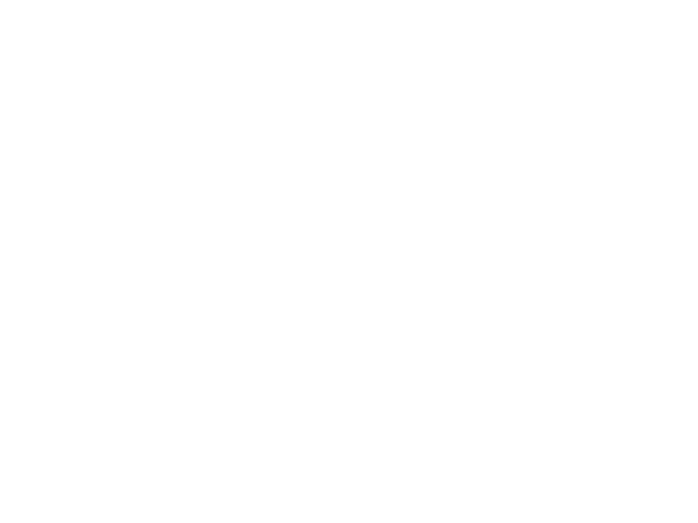

In [15]:
# G-C.c=
# T30 = T30BU.copy()
mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':(1e-6 * 12.0107 *1800),
        'fch4':(1e-6 * 12.0107 *1800)}
T30['fch4']*=mult['fch4']
T30['fco2']*=mult['fco2']
T30['ER']*=mult['fco2']
for target,name in zip([fch4,fco2],['NME','NEE']):
    target.cols = []
    print(name)
    print(target.Y_fill)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


for target,name in zip([fch4,fco2],['NME_est','NEE_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


for target,name in zip([fch4_fixed,fco2_fixed,ER_interp,#ER_10,ER_0,
                        ER_fixed],
                       ['NME_fixed_est','NEE_fixed_est','ER_interp_est',
#                         'ER_10_est','ER_0_est',
                        'ER_fixed_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]*mult[target.target]
#         B = target.RST.Master[target.target].fillna(T30['Fill'])
#         T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')
# print(ER.Best)
T30['Night'] = 0
T30.loc[T30['PPFD_Max']<10,'Night']=1
plt.figure()
plt.plot(T30.loc[T30['fco2']>0,'Night'].cumsum(),color= 'b')
T30['Night'] = 0
T30.loc[T30['PPFD_Avg']<10,'Night']=1
plt.plot(T30.loc[T30['fco2']>0,'Night'].cumsum(),color= 'r')
# print(T30.loc[T30['fco2']>0,'Night'].sum())
# T30['Night'] = 0
# T30.loc[T30['PPFD_Min']<10,'Night']=1
# plt.plot(T30.loc[T30['fco2']>0,'Night'].resample('D').sum(),color= 'g')
plt.show()

In [16]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)

mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':(1e-6 * 12.0107 *1800),
        'fch4':(1e-6 * 12.0107 *1800)}

Temp = T30.copy()
Estimates = []
CIs = []
SE = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
#            'ER':ER,
           'NME':fch4,
           'NEE_est':fco2,
#            'ER_est':ER,
#            'ER_0_est':ER_0,
#            'ER_10_est':ER_10,
           'ER_interp_est':ER_interp,
           'NME_est':fch4,
           'NEE_fixed_est':fco2_fixed,
           'ER_fixed_est':ER_fixed,
           'NME_fixed_est':fch4_fixed}
for Var in ['NEE','NEE_fixed_est',#'ER_est',
#             'ER_10_est','ER_0_est',
            'ER_interp_est','ER_fixed_est','NME','NME_fixed_est']:#,
    target = Targets[Var]
    if Var == 'NEE' or Var == 'NME' or Var == 'ER':
        CIPI = 'CI'
        Fluxes.append(Var.split('_')[0])
        Type.append('EC Obs.')
        std = MI(Temp,target.cols)**.5#,Var,n=30)
        print((std/Temp.shape[0]**.5)*48*stats.t.ppf(1-.025,Temp[Var].count()))
        Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())*48#*mult[target.target]

    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'CI'
        Type.append('EC Obs.')
        std = (Temp[Var+'_Var_reg']).mean()**.5*mult[target.target]*48
        Int=((std)/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())*48#*mult[target.target
    SE.append(std)

    U = Temp[Var].sum()/(Temp.shape[0]/48)#*mult[target.target]
    Estimates.append(U)
    CIs.append(Int)
    
    if Var.split('_')[-1]=='fixed':
        Scale.append('Basin')
    elif len(Var.split('_'))>1:
        if Var.split('_')[1]=='fixed':#len(Var.split('_'))<2:
            Scale.append('Basin')
        else:
            Scale.append('Footprint')
    else:
        Scale.append('Footprint')
    
    Samples.append(Temp[Var].count())
    IntType.append(CIPI)
           
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
# print(Data)
Res = pd.DataFrame(data = Data)
# print(Res)
Cres = pd.read_csv('C:\\Users\\wesle\\Illisarvik_Processing/ScaledChamberFluxes.csv',
                   index_col=[0],delimiter = ',')
                   
# print(Cres)

All = Res.append(Cres).sort_values('Flux').reset_index(drop=True)
# Tem = (All.loc[All['Type'] == 'NN est.'])
Tem = (All.loc[((All['Type'] == 'NN est.')|(All['Type'] == 'EC Obs.'))])
# print(Tem)
CO2=(Tem.loc[Tem['Flux'] == 'NEE','Estimates']).values[0]
CH4=(Tem.loc[Tem['Flux'] == 'NME','Estimates']).values[0] #*28*1e-3

# print(All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']])

# print(Temp['NEE'].mean(),Temp['NEE'].std()/Temp['NEE'].count()**.5*stats.t.ppf(1-.05,Temp['NEE'].count()))

# plt.figure()
# plt.plot(T30['NEE'])#*mult['fco2']*48)
# plt.plot(T30['fco2'])#*mult['fco2']*48)
print(T30[['Upland','Sedge','Sparse','Grass','Shrub','Out_of_Basin']].mean())
All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
# print(ER_fixed.Best)
# print(T30['ER'].mean()*48)
# print(T30['ER_interp_est'].mean()*48)
# # print(T30['ER'].count())
# print(T30['ER'].fillna(T30['ER_interp_est']).mean()*48)

0.17910187173203776
0.5432682137252425
Upland          0.062524
Sedge           0.108134
Sparse          0.022291
Grass           0.375453
Shrub           0.365338
Out_of_Basin    0.122589
dtype: float64


,Flux,Type,Scale,Estimates,SE,95% CI/PI
0,ER,EC Obs.,Footprint,2.587885,0.397056,1.022131
1,ER,EC Obs.,Basin,2.587885,0.397056,1.022131
2,ER,Chamber Obs.,Footprint,4.367188,0.423816,0.844234
3,ER,Chamber Obs.,Basin,4.008449,0.421306,0.840870
4,NEE,EC Obs.,Footprint,-1.581130,0.069574,0.179102
5,NEE,EC Obs.,Basin,-1.590995,0.309239,0.796064
6,NME,EC Obs.,Footprint,8.566824,0.211038,0.543268
7,NME,EC Obs.,Basin,5.639826,3.755232,9.666987
8,NME,Chamber Obs.,Footprint,13.630093,4.000197,7.968323
9,NME,Chamber Obs.,Basin,14.968051,4.331294,8.644676


<IPython.core.display.Javascript object>


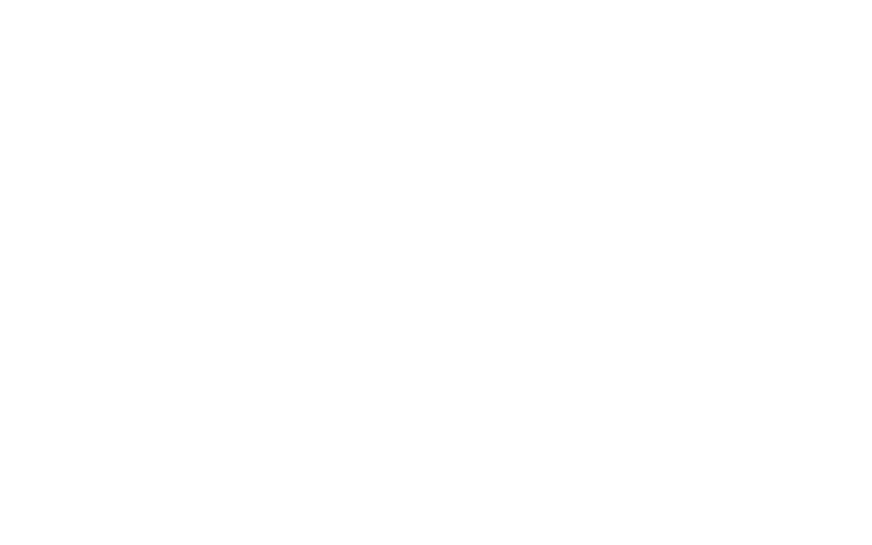

Dates
194    0.952571
196    0.929873
197    0.921098
199    0.924227
200    0.916467
208    0.915692
210    0.901132
212    0.965631
214    0.908941
216    0.958959
218    0.966473
dtype: float64
Sedge     0.137613
Sparse    0.030462
Shrub     0.328498
Grass     0.373889
Upland    0.065575
dtype: float64


In [17]:


Dates = [194, 196, 197, 199, 200, 208, 210, 212, 214, 216, 218]
plt.figure(figsize=(8,5))
i=0
Temp = T30.loc[T30.index.dayofyear.isin(Dates)==True]
Temp = Temp.between_time('9:00:00', '19:00:00')
Temp = Temp.groupby(Temp.index.dayofyear).mean()
for frac in ['Sedge','Sparse','Shrub','Grass','Upland']:
#     Day = T
    plt.bar(Temp.index+i,Temp[frac],
            label=frac,width=.13)
    i+=.14
plt.legend(ncol=5)
# for 
Daily = pd.DataFrame(columns=['Sedge','Sparse','Shrub','Grass','Upland'])
for d in Dates:
    Temp = T30.loc[T30.index.dayofyear == d]
    Temp = Temp.between_time('9:00:00', '19:00:00')
    Daily = Daily.append(Temp[['Sedge','Sparse','Shrub','Grass','Upland']].mean(),ignore_index=True)
#     plt.bar(np.linspace(0,1,6)+d,
#             Temp[['Sedge','Sparse','Shrub','Grass','Upland','Upland']].mean(),
#             color=['r','g','b','y','c','k'],
#             width=.12)
#     i += 1 
#     Temp = Mapper(Temp,fch4_fixed,'NME_fixed_est',Fill = False,DarkTarget=T30_Fixed)
# print(Daily.reset_index(Dates))
Daily['Dates']=Dates
Daily = Daily.set_index(['Dates'])
# Daily = Daily/Daily.sum(axis=1)
# for col in Daily.columns
print(Daily.sum(axis=1))
Daily.rename({'Upland':'Upland'},inplace=True)
Daily.to_csv('C:\\Users\\wesle\\Illisarvik_Processing/Daily.csv',index=True)

Temp = T30.loc[T30.index.dayofyear.isin(Dates)==True]
Temp = Temp.between_time('9:00:00', '19:00:00')
print(Temp[['Sedge','Sparse','Shrub','Grass','Upland']].mean())

<IPython.core.display.Javascript object>


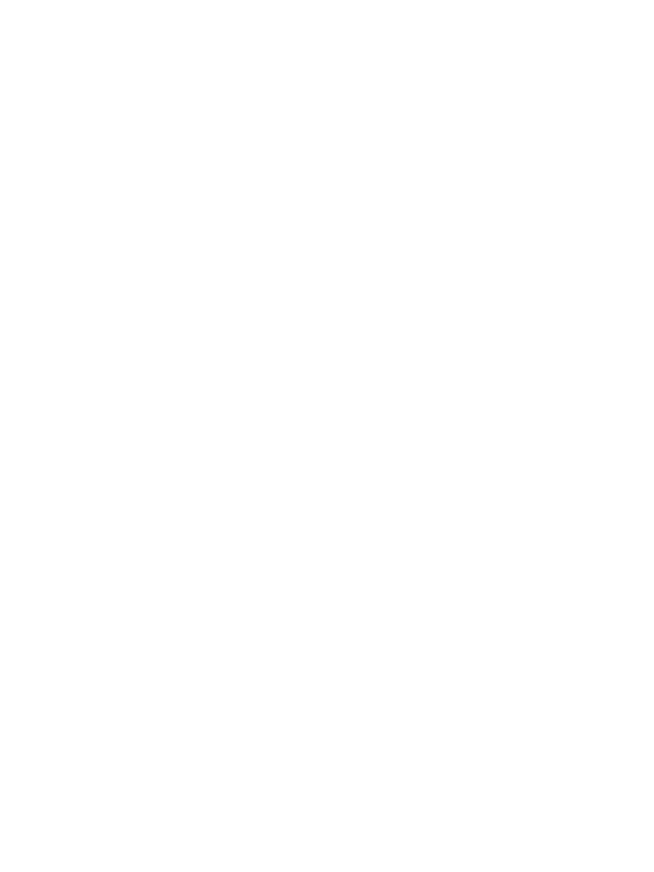

[[ 1.         -0.29619014]
 [-0.29619014  1.        ]]
[[1.         0.22476011]
 [0.22476011 1.        ]]
CH4 Flux  (mg/m2/h)    16.762126
CO2 Flux (g/m2/h)       4.248854
ER                      2.500879
NME                     7.494663
dtype: float64
CH4 Flux  (mg/m2/h)    12.067507
CO2 Flux (g/m2/h)       1.111952
ER                      0.618428
NME                     3.765257
dtype: float64
[58.63143312 50.53718218 31.54682419]
1.9922541723945966
3.1111914473011506
1.118937274906554
-0.2947439171198634
1.8367723296


In [18]:
FWC = pd.read_csv('FWChamber.csv')
FWC=FWC.set_index('Date')
# print(FWC)
FWC['ER']=0
FWC['NME']=0
# print(FWC)
# FWC
for d in Dates:
    Temp = T30.loc[T30.index.dayofyear == d].between_time('9:00:00', '19:00:00').mean()
#     print(FWC.loc[FWC.index==d])
#     print(Temp['ER_interp_est'].values[0])
    FWC.loc[FWC.index==d,'ER']=Temp['ER_interp_est']*2#.values[0]
    FWC.loc[FWC.index==d,'NME']=Temp['NME']*2#.values[0]
#     print(Temp[['ER_interp_est','NME']].mean()*48)
# print(FWC)
fig,ax=plt.subplots(2,1,figsize=(6,8))

ax[0].scatter(FWC['CO2 Flux (g/m2/h)'],FWC['ER'])
ax[1].scatter(FWC['CH4 Flux  (mg/m2/h)'],FWC['NME'])

print(np.corrcoef(FWC['ER'],FWC['CO2 Flux (g/m2/h)']))
print(np.corrcoef(FWC['NME'],FWC['CH4 Flux  (mg/m2/h)']))

print(FWC.mean()*24)
print(FWC.std()*24/FWC.count()**.5*stats.t.ppf(1-.025,FWC.count()))

Rus = np.array([56.5,48.7,30.4])
print(Rus*1e-6 * 12.0107 *1800*48)

print(7.3*12.0107/44.0095)
print(11.4*12.0107/44.0095)


print(11.4*12.0107/44.0095 -7.3*12.0107/44.0095)

print(-.3* 1e-3 *1800*12.0107/44.00958*2)

print(1.77*1e-6 * 3600  * 12.0107*24)

<IPython.core.display.Javascript object>


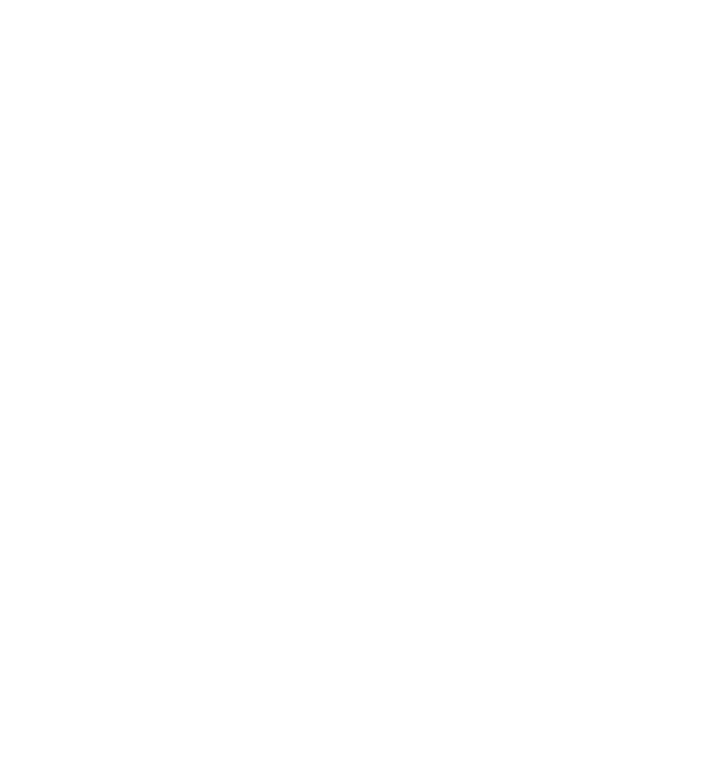

In [19]:
fig,ax = plt.subplots(2,1,figsize = (6.5,7),sharex=True)


ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0))#, rowspan=2)
ax3 = plt.subplot2grid((3, 1), (2, 0))
Labels =['EC Obs.\nFootprint Scale','NN est.\nBasin Scale','Chamber\nFootprint Scale','Chamber\nBasin Scale']
ax1.bar([0,1],All.loc[All['Flux']=='NEE','Estimates']*-1,
        yerr = All.loc[All['Flux']=='NEE','SE'],color='green',label='NEE')

ax2.bar([0,1,2,3],All.loc[All['Flux']=='ER','Estimates'],
        yerr = All.loc[All['Flux']=='ER','SE'],color='brown',label='ER')

Conv = 28*1e-3
ax3_2=ax3.twinx()
ax3.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates'],
        yerr = All.loc[All['Flux']=='NME','SE'],color='red',label='NME')
ax3_2.bar([0,1,2,3],All.loc[All['Flux']=='NME','Estimates']*Conv,color='None',label='')

ax3.set_xticks([0,1,2,3])
ax1.set_xticks([0,1,2,3])
ax1.set_xlim(ax2.get_xlim())
yt = ax1.get_yticks()
ax1.set_yticks(yt)
ax1.set_yticklabels(yt*-1)
ax2.set_xticks([0,1,2,3])
ax3.set_xticklabels(Labels)
ax1.set_xticklabels([])
ax2.set_xticklabels([])
# ax1.legend(loc=4)
# ax2.legend(loc=2)
ax1.grid()
ax2.grid()
ax1.set_title('a. NEE',loc='left')
ax1.set_ylabel('g C-CO$_2$ m$^{-2}$ d$^{-1}$')
ax2.set_title('b. ER',loc='left')
ax2.set_ylabel('g C-CO$_2$ m$^{-2}$ d$^{-1}$')
# ax3.legend(loc=2)
ax3.grid()
ax3.set_title('c. NME',loc='left')
ax3.set_ylabel('mg C-CH$_4$ m$^{-2}$ d$^{-1}$')
ax3_2.set_ylabel('g C-CO$_2$ eq. m$^{-2}$ d$^{-1}$')
# ax3.bar([2,3],[0,0],
#         color='None')
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig11.png')  

In [20]:


T30['GPP'] = -1*T30['NEE_est']+T30['ER_interp_est']
T30['GPP_fixed'] = -1*T30['NEE_fixed_est']+T30['ER_fixed_est']


T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
HafHourly = T30.resample('D').mean()
# v='NEE'

HafHourly['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').sum()
HafHourlys = T30.resample('D').std()
for target,v in zip([fco2,fch4],['NEE','NME']):
#     HafHourly[v+'Pooled_CI'] = 0
#     HafHourly[v+'Pooled_PI'] = 0
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
#         if v
#         pooled_std = 
        HafHourly.loc[HafHourly.index==day,v+'_Var']=MI(Samp,target.cols,JustBetween=True)*48#/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
#         HafHourly.loc[HafHourly.index==day,v+'_Std']=pooled_std#*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])

for target,v in zip([ER_interp,fco2,fch4],['ER_interp_est','NEE_est','NME_est']):
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        HafHourly.loc[HafHourly.index==day,v+'_Var']=(Samp[v+'_Var_reg']).mean()**.5*mult[target.target]#*48
    

# Daily['ER_Sum'] = HafHourly['ER']+0
Daily = T30.resample('D').sum()
# Daily['ER_CI'] = (HafHourly['ER_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['ER_interp_est_CI'] = (HafHourly['ER_interp_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_CI'] = (HafHourly['NEE_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_est_CI'] = (HafHourly['NEE_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_CI'] = (HafHourly['NME_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_est_CI'] = (HafHourly['NME_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#

# print(Daily[['ER_CI','ER_est_CI']])
# print(HafHourly['NEE_est_Var']/(48**.5)*stats.t.ppf(1-.025,48)*48)
# print(Daily[['ER','ER_CI']])
# print(HafHourly)*
Weekly = Daily[['NEE','NME','ER_interp_est','GPP']].resample('W').mean()
print(Weekly['NME']*16.01/12.01)
print(Weekly[['NEE','ER_interp_est','GPP']]*44.01/12.01)

datetime
2016-07-17    18.270017
2016-07-24    10.838341
2016-07-31    10.002897
2016-08-07     6.367376
Freq: W-SUN, Name: NME, dtype: float64
                 NEE  ER_interp_est        GPP
datetime                                      
2016-07-17 -6.834701       6.986816  13.836117
2016-07-24 -4.957398       9.703981  14.648466
2016-07-31 -5.398889      12.019564  17.582573
2016-08-07 -5.852971       9.330710  15.126512


<IPython.core.display.Javascript object>


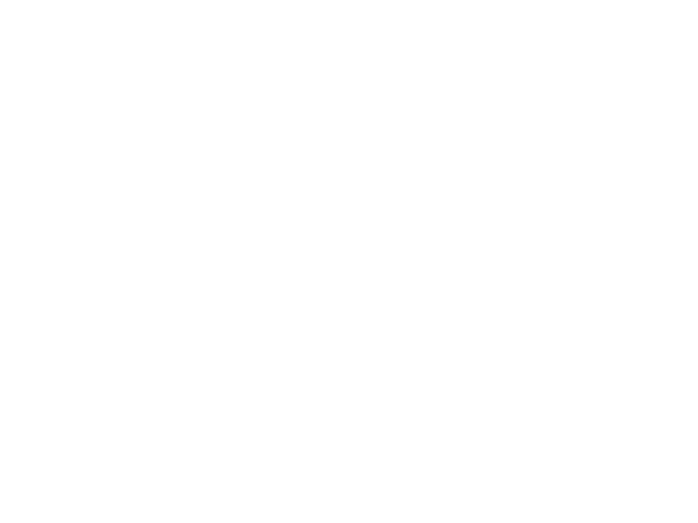

0.32822614908218384
      GPP
Day      
193  24.0
194  24.0
195  24.0
196  24.0
197  24.0
198  24.0
199  24.0
200  24.0
201  24.0
202  24.0
203  24.0
204  24.0
205  24.0
206  24.0
207  24.0
208  24.0
209  24.0
210  24.0
211  24.0
212  24.0
213  24.0
214  24.0
215  24.0
216  24.0
217  24.0
218  24.0
219  24.0


<IPython.core.display.Javascript object>


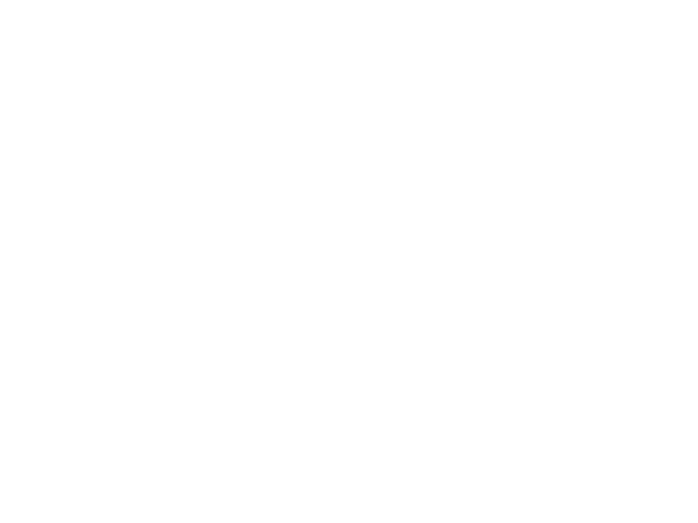

In [21]:
# mult = 1#24
# print('Cbal', 24*(T30['NEE'].mean()*mult+T30['NME'].mean()*mult*1e-3*28))
# print('Cbal', T30['NEE_fixed_est'].mean()*mult+T30['NME_fixed_est'].mean()*mult*1e-3*28)

# print(H2['NEE']/48)
# print(H1['NEE'])
# print(T30['Temp'])
# print(T30['AirTC_Avg'].mean())
# print(T30['fco2'].mean()*48)
# print(Daily['fco2'].mean())


Hr = T30.groupby(T30.index.hour).mean()*2
fig,ax = plt.subplots(3,1)
# ax[0].bar(Hr.index,Hr['ER_interp_est'],color='b')
ax[0].bar(Hr.index,Hr['ER_interp_est'],color='brown')
ax[1].bar(Hr.index,Hr['GPP'],color='g')
ax[2].bar(Hr.index,Hr['NME'],color='r')
print(Hr['GPP'].max())
# print(Hr.loc[Hr['GPP']>0,'GPP'])
# T30['GPP'] = -1*(T30['NEE']-T30['ER_interp_est'])
T30['Day']=T30.index.dayofyear
print(T30.loc[T30['GPP']>=0,['GPP','Day']].groupby('Day').count()/2)

plt.figure()
DailyMax = T30[['ER_interp_est','GPP','Day']].groupby('Day').max()
plt.plot(T30.loc[T30['GPP']>=0,['GPP','Day']].groupby('Day').count()/2)

<IPython.core.display.Javascript object>


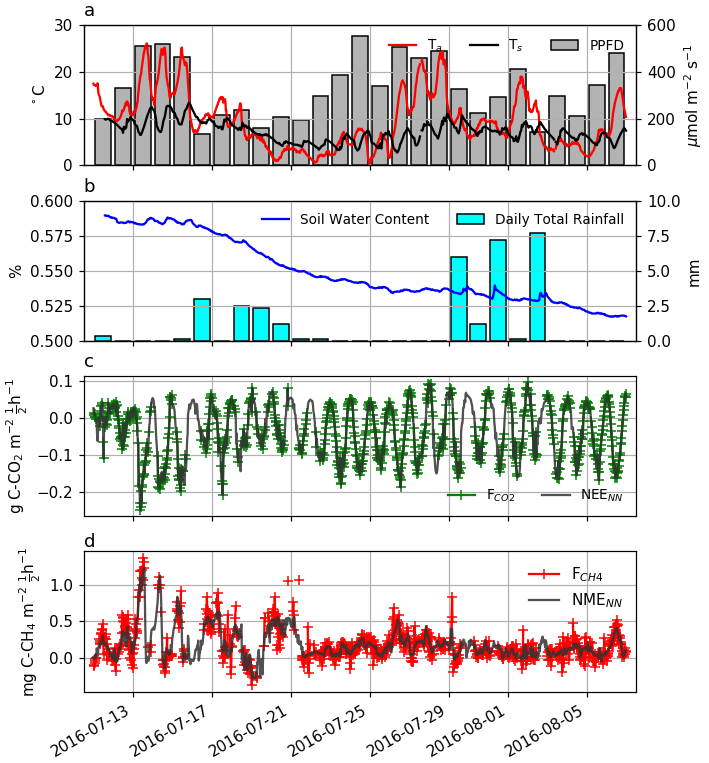

In [40]:
fig,ax = plt.subplots(4,1,figsize = (6.5,7),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'T$_a$')
ax[0].plot(T30['Temp'],color='black',label = 'T$_s$')
ax[0].bar(T30.index,T30['PPFD_Avg']*np.nan,facecolor=[.7,.7,.7],edgecolor='black',label = 'PPFD')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.bar(HafHourly.index+datetime.timedelta(hours=12),HafHourly['PPFD_Avg'],
         facecolor=[.7,.7,.7],edgecolor='black',label = 'PPFD')
yax2.set_ylim(0,600)

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend(ncol = 3,fontsize=9,loc=0,facecolor='None',edgecolor='None')
ax[0].set_title('a',loc='left')

yax2 = ax[1].twinx()
yax2.bar(Daily.index+datetime.timedelta(hours=12),Daily['Rain_mm_Tot'],
         facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
# ax[1].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,label = 'Daily Total Rainfall')
yax2.set_ylim(0,10)

ax[1].plot(T30['VWC'],color='blue',label = 'Soil Water Content')
# ax[1].plot(fco2.RST.Master['VWC'],color='orange',label = 'Soil Water Content')
ax[1].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].set_title('b',loc='left')
ax[1].legend(ncol=2,fontsize=9,facecolor='None',edgecolor='None')

ax[0].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[1].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])

# ax[2].bar(Daily.index+datetime.timedelta(hours=12),Daily['ER_interp_est'],
#           error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           edgecolor = 'black',facecolor=[1,1,.5,.5],label='ER')
# ax[2].bar(Daily.index+datetime.timedelta(hours=12),Daily['NEE'],
#           edgecolor = 'black',facecolor=[0,1,0,.75],
#           error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           label='NEE')
gap=[.2,.2,.2,.85]
ax[2].plot(T30.index,T30['fco2'],label='F$_{CO2}$',color='g',marker='+')
ax[2].plot(T30.index,T30['NEE'],label='NEE$_{NN}$',color=gap)
[0,1,0,.75]
ax[2].grid()
ax[2].set_title('c',loc='left')
ax[2].set_ylabel(r'g C-CO$_2$ m$^{-2}$ $\frac{1}{2}$h$^{-1}$')#${\mu}$mol
ax[2].legend(fontsize=9,facecolor='None',edgecolor='None',ncol=2,loc=0)

ax[2].set_xticklabels([])


# ax[3].bar(Daily.index+datetime.timedelta(hours=12),Daily['NME'],
#           edgecolor = 'black',facecolor=[1,0,0],
#           error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           label ='NME')
ax[3].plot(T30.index,T30['fch4'],label='F$_{CH4}$',color='r',marker='+')
ax[3].plot(T30.index,T30['NME_est'],label='NME$_{NN}$',color=gap)
ax[3].grid()
ax[3].set_title('d',loc='left',pad = -.3)
ax[3].set_ylabel(r'mg C-CH$_4$ m$^{-2}$ $\frac{1}{2}$h$^{-1}$')#nmol

ax[2].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
ax[3].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
# ax[3].scatter(Dates['Date'],Dates['Value']*0,marker = '*',label = 'Chamber Observations')
ax[3].legend(facecolor='None',edgecolor='None')

fig.autofmt_xdate()
plt.tight_layout(pad=0.25)

# plt.savefig('Fig3.png',dpi=300)

plt.savefig('Fig2.png',dpi=300)


90.09490636495983
0.20110056610007998


<IPython.core.display.Javascript object>


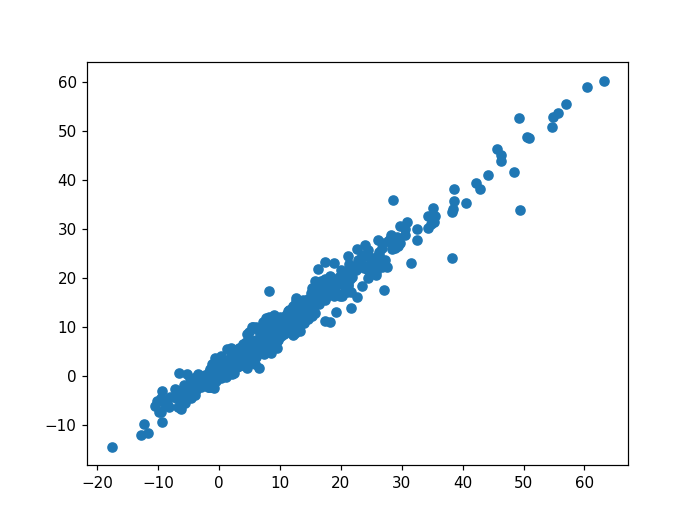

['AirTC_Avg', 'wind_speed', 'VWC', 'Sedge', 'Grass']
4.116510336369039
0.963497628111777


In [41]:
fch4.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])


y_pred = reg.predict(fch4.RST.Data[fch4.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))
y_pred2 =  reg.predict(fch4.RST.Data[fch4.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fch4.RST.Data['y_pred2']=y_pred2
plt.figure()
Var = 'Sedge'
# Var = 'PPFD_Avg'
# plt.scatter(fch4.RST.Data[Var],fch4.RST.Data['y_pred2'])

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(min_samples_leaf=1,random_state=1)
print(fch4.params['Inputs'])
forest.fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])

y_pred = forest.predict(fch4.RST.Data[fch4.params['Inputs']])
# y_pred3=forest.predict(fch4.RST.Data[fch4.params['Inputs']])
fch4.RST.Data['y_pred3']=y_pred
plt.scatter(fch4.RST.Data['fch4'],fch4.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))

1.574169366506478 0.061644134007528564


<IPython.core.display.Javascript object>


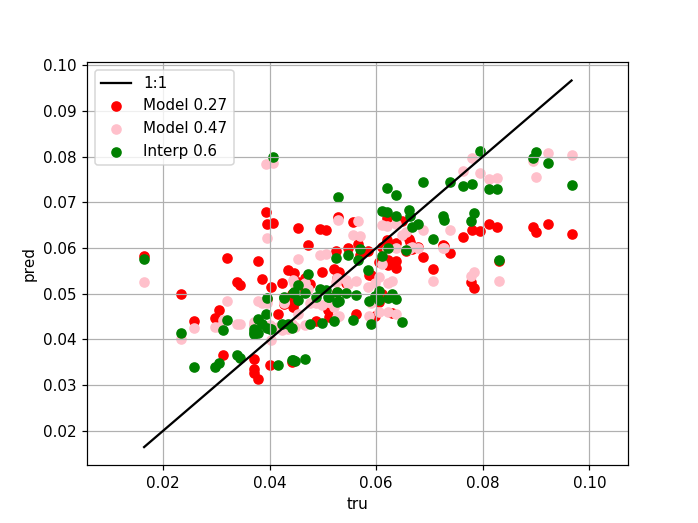

Mean ER:

R2 Score:
ER_est:  0.6045698008190319 ER2:  0.26731090298216975 ER3:  0.4746881456105271

MSE:
ER_est:  0.010209579536145617 ER2:  0.013897375897425849 ER3:  0.011767427756160714
95
fco2             0.054473
ER_interp_est    0.053728
dtype: float64 0.05450854535771542


In [42]:
## R2 = .58 for ER - Modeled @ PPFD_Avg<10
def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))

Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_interp_est',#'ER_fixed_interp_est',
#                                    'Temp_10_est','Temp_0_est',
#                                    'ER_10_est','ER_0_est',
                                   'AirTC_Avg','VPD','Sedge','Shrub','VWC']].dropna()
# Dark = Dark.loc[Dark['VWC']>Dark['VWC'].quantile(.5)]
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 45.9262144,0.5875255,2.7508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))
print(popt_r2[0],popt_r2[1])
#p0=( 74.59262144,0.8875255,2.27508822)
# print(metrics.r2_score(Dark['fco2'],R_func2(Dark['Temp'],*popt_r2)))

plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),2)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)),2))
           )
Dark['ER3'] = (R_func2(Dark['AirTC_Avg'],*popt_r2))
# plt.scatter(Dark['fco2'],Dark['ER_interp_est'],c='blue',
#             label='Est '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER__est']),2)))
plt.scatter(Dark['fco2'],Dark['ER_interp_est'],c='green',
            label='Interp '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_interp_est']),2)))
# plt.scatter(Dark['fco2'],Dark['ER_0_est'],c='pink',
#             label='0 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_0_est']),2)))
# plt.scatter(Dark['fco2'],Dark['ER_10_est'],c='brown',
#             label='10 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_10_est']),2)))
# Dark[['Temp_0_est','Temp_10_est']]*=mult['fco2']
# plt.scatter(Dark['fco2'],Dark['Temp_0_est'],c='yellow',
#             label='Temp_0 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['Temp_0_est']),2)))
# plt.scatter(Dark['fco2'],Dark['Temp_10_est'],c='cyan',
#             label='Temp_10 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['Temp_10_est']),2)))
# plt.colorbar()
plt.plot([Dark['fco2'].min(),Dark['fco2'].max()],[Dark['fco2'].min(),Dark['fco2'].max()],
         label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()

# plt.xlim(0,1)
# plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','ER3','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
popt_p3, pcov3 = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER3']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = P_func(T30['PPFD_Avg'],*popt_p)
T30['GPP3'] = P_func(T30['PPFD_Avg'],*popt_p3)
T30['NEE2'] = T30['ER2']-T30['GPP2']
T30['NEE3'] = T30['ER3']-T30['GPP3']


Temp = T30.loc[np.isnan(T30['fco2'])==False]
print('Mean ER:')
# print(Temp[['ER','ER_est','ER2','ER3']].mean()*mult['fco2'])
# print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER_est: ',metrics.r2_score(Dark['fco2'],Dark['ER_interp_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),
     'ER3: ',metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)))
print()
print('MSE:')
print('ER_est: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_interp_est'])**.5,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,
     'ER3: ',metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
print(Dark['fco2'].count())
print(Dark[['fco2','ER_interp_est']].mean(),R_func2(Dark['AirTC_Avg'],*popt_r2).mean())
# for q in [0,.25,.5,.75,1]:
#     print(Dark[['VWC','Shrub','Sedge']].quantile(q))
#     print()
# plt.figure()
# plt.scatter(Dark['ER_est'],Dark['ER_interp_est'])
# print(Dark['ER_est'].mean(),Dark['ER_interp_est'].mean())
# print(ER.Model_Selection)
# plt.figure()
# plt.scatter(Dark['ER_fixed_est'],Dark['ER_est'])
# plt.scatter(Dark['AirTC_Avg'],Dark['ER_0_est'])
# plt.scatter(Dark['AirTC_Avg'],Dark['ER_est'])
# print(ER.Model_Selection,ER_0.Model_Selection)
# print(ER_10.Model_Selection)

FP Weighted RE:
3.3271264894996113
0.07689450069775691
FPEst
6.456139106441638


<IPython.core.display.Javascript object>


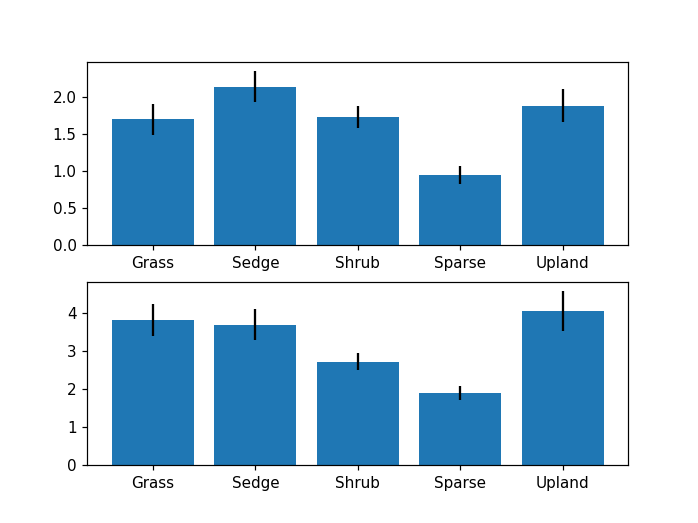

             Q10       R10
Class                     
Grass   1.695000  3.825000
Sedge   2.135000  3.705000
Shrub   1.723333  2.733333
Sparse  0.950000  1.900000
Upland  1.880000  4.065000
1.574169366506478 1.4256763184199774


<IPython.core.display.Javascript object>


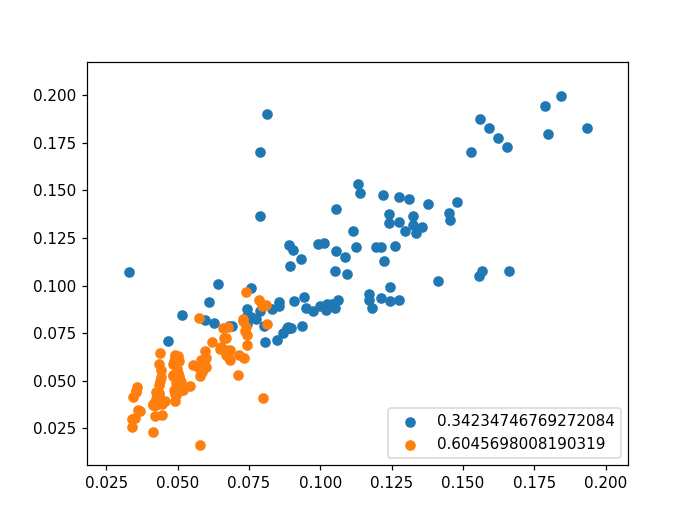

95
0.34234746769272084
0.026333051230869032
0.6045698008190319
0.020419159072291235
0.4746881456105271
0.02353485551232143
3.0115552493848234


In [43]:

FPRatios = {'Sedge':.109629,
            'Sparse':.022089,
            'Shrub':.370768,
            'Grass':.368608,
            'Upland':.062327,
            'Out_of_Basin':0
}

Index = ['Tundra',
'Peat Plateau',
'Low Willow',
'Dense Willow',
'Tall Willow',
'Cotton Grass',
'Wet Sedge_1' ,
'Wet Sedge_2' ,
'Grass',
'Bare Ground']

Class = ['Upland','Upland','Shrub','Shrub','Shrub','Grass','Sedge','Sedge','Grass','Sparse']

Columns = ['Q10','CIQ','R10','CIR','Q10_uv','CIQ_uv','R10_uv','CIR_uv']

Data =[[1.72, (0.23), 5.35, (0.74), 1.56, (0.30), 1.58, (0.27)],
[2.04, (0.22), 2.78, (0.32), 1.35, (0.33), 1.79, (0.34)],
[1.93, (0.17), 3.64, (0.33), 1.74, (0.27), 2.46, (0.35)],
[1.57, (0.16), 2.40, (0.21), 1.42, (0.22), 2.21, (0.26)],
[1.67, (0.11), 2.16, (0.10), 1.78, (0.36), 1.55, (0.23)],
[1.86, (0.20), 3.97, (0.33), 1.45, (0.37), 2.62, (0.46)],
[2.23, (0.19), 3.85, (0.35), 1.38, (0.48), 1.98, (0.54)],
[2.04, (0.23), 3.56, (0.46), 1.05, (0.47), 2.36, (0.74)],
[1.53, (0.21), 3.68, (0.50), 1.45, (0.34), 2.97, (0.63)],
[0.95, (0.12), 1.90, (0.18)]]

Fixes = pd.DataFrame(data = Data, index = Index, columns = Columns)
Fixes['Class']=Class
Classes=Fixes.groupby('Class').mean()
# print(popt_r2[0],popt_r2[1]/mult['fco2'])
# Temps = np.arange(0,25)
# plt.figure(figsize=(10,10))
B=[]


FPRatios = {'Sedge':0.122590,
            'Sparse':0.083902,
            'Shrub':0.482874,
            'Grass':0.279263,
            'Upland':0.0,
            'Out_of_Basin':0.0
}
i=0
for F in Classes.index.unique():
    V = Classes.loc[Classes.index==F,['Q10','R10']].values[0]
#     plt.plot(V[1]*V[0]**((T30['AirTC_Avg'].values-10)/10),label = F,linewidth = 2)
#     print(F,np.nanmean(V[1]*V[0]**((T30['AirTC_Avg'].values-10)/10)))
    B.append(np.nanmean(V[1]*V[0]**((T30['AirTC_Avg'].values-10)/10))*FPRatios[F])
    if i == 0:
        T30['RE'] = (V[1]*V[0]**((T30['AirTC_Avg'].values-10)/10)*T30[F])
        i+=1
    else:
        T30['RE'] += (V[1]*V[0]**((T30['AirTC_Avg'].values-10)/10)*T30[F])
print('FP Weighted RE:')
print(T30['RE'].mean())
print(T30['RE'].std()/(T30['RE'].count()**.5)*stats.t.ppf(1-.025,T30['RE'].count()))

# plt.plot((0.06164413*1.57416937 **((T30['AirTC_Avg'].values-10)/10))/mult['fco2'],linewidth = 5,label='EC')
# plt.legend(fontsize = 15)

T30['RE_D']=0.06164413*1.57416937 **((T30['AirTC_Avg'].values-10)/10)#*mult['fco2']*2

print('FPEst')
print(np.sum(np.array(B))*mult['fco2']*48)
# print()
# print(np.nanmean(0.06164413*1.57416937 **((T30['AirTC_Avg'].values-10)/10))*48)
    
fig,ax=plt.subplots(2,1)
# Classes['Q10'].plot.bar()
ax[0].bar(Classes.index,Classes['Q10'],yerr=Classes['CIQ'])
ax[1].bar(Classes.index,Classes['R10'],yerr=Classes['CIR'])
# Classes['R10']*=mult['fco2']
print(Classes[['Q10','R10']])
print(popt_r2[0],popt_r2[1]/mult['fco2'])


Temp = T30[['ER','ER3','RE','RE_D','ER_interp_est']].dropna()
# Temp['RE']*=2
plt.figure()
plt.scatter(T30['ER']*2,T30['RE']/24,label=metrics.r2_score(Temp['ER']*2,Temp['RE']/24))

plt.scatter(T30['ER_interp_est'],T30['ER'],label=metrics.r2_score(Temp['ER'],Temp['ER_interp_est']))
plt.legend()

print(T30['ER'].count())

print(metrics.r2_score(Temp['ER']*2,Temp['RE']/24))
print(metrics.mean_squared_error(Temp['ER']*2,Temp['RE']/24)**.5)
print(metrics.r2_score(Temp['ER'],Temp['ER_interp_est']))
print(metrics.mean_squared_error(Temp['ER'],Temp['ER_interp_est'])**.5*2)
print(metrics.r2_score(Temp['ER'],Temp['ER3']))
print(metrics.mean_squared_error(Temp['ER'],Temp['ER3'])**.5*2)
print(T30['ER3'].mean()*48)

<IPython.core.display.Javascript object>


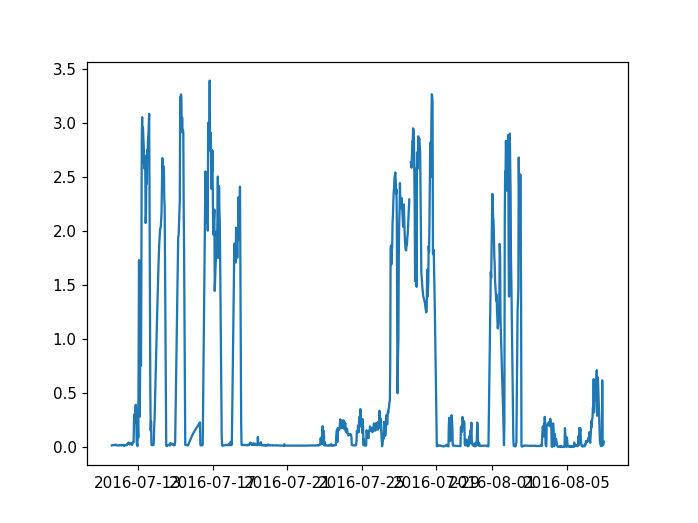

13.759829581821384
1.2011960610096437


<IPython.core.display.Javascript object>


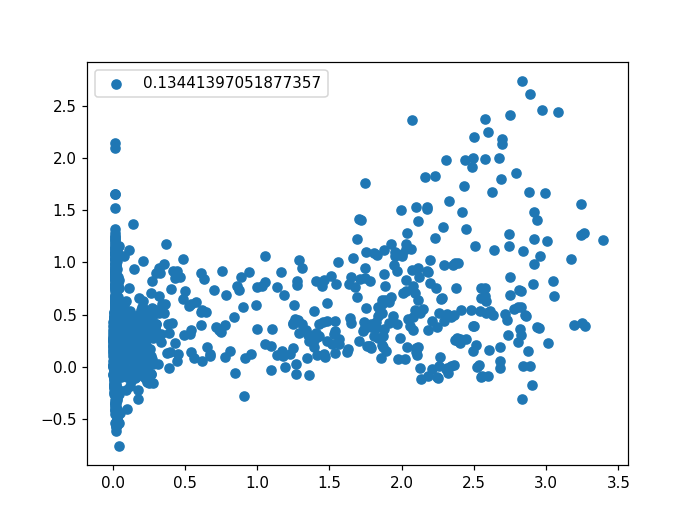

In [44]:


for F in ['Sedge','Shrub','Sparse','Grass','Upland']:
    T30[F]=T30[F].interpolate()

F = 'Sedge'
# const = -0.704515
# Temp = 0.236575
# VWC = 3.996366
# AirTC_Avg = 0.123908
const=-2.970312
Temp=0.458171
VWC=8.153707
AirTC_Avg=0
T30[F+'CH4'] = ((T30['Temp']*Temp+T30['VWC']*VWC+T30['AirTC_Avg']*AirTC_Avg+const)*T30[F])

F = 'Shrub'
# const = -0.493459
# Temp = -0.002420
# VWC =  0.954898
# AirTC_Avg =  0.000813
const = -0.515631
Temp = -0.001149
VWC = 0.997676
AirTC_Avg=0
T30[F+'CH4'] = ((T30['Temp']*Temp+T30['VWC']*VWC+T30['AirTC_Avg']*AirTC_Avg+const)*T30[F])

F = 'Grass'
# const =  0.170470
# Temp = -0.006983
# VWC = -0.281907
# AirTC_Avg =  0.003969
const = 0.136553
Temp = 0.000740
VWC = -0.227346
AirTC_Avg=0
T30[F+'CH4'] = ((T30['Temp']*Temp+T30['VWC']*VWC+T30['AirTC_Avg']*AirTC_Avg+const)*T30[F])

F = 'Upland'
# const =  0.189581
# Temp =  0.009489
# VWC = -0.432704
# AirTC_Avg = -0.004908
const=0.316501
Temp=-0.000195
VWC=-0.654952
AirTC_Avg=0
T30[F+'CH4'] = ((T30['Temp']*Temp+T30['VWC']*VWC+T30['AirTC_Avg']*AirTC_Avg+const)*T30[F])


F = 'Sparse'
# const = -0.409728
# Temp = -0.003057
# VWC =  0.772074
# AirTC_Avg = 0.000458
const = -0.412372
Temp = -0.002003
VWC = 0.773983
AirTC_Avg=0
T30[F+'CH4'] = ((T30['Temp']*Temp+T30['VWC']*VWC+T30['AirTC_Avg']*AirTC_Avg+const)*T30[F])
T30['CH4Sum']=0
for F in ['Sedge','Shrub','Sparse','Grass','Upland']:
    T30['CH4Sum']+=T30[F+'CH4']
plt.figure()
plt.plot(T30['CH4Sum'])
print(T30['CH4Sum'].mean()*24)
print(T30['CH4Sum'].std()/(T30['CH4Sum'].count()**.5)*stats.t.ppf(1-0.025,T30['CH4Sum'].count())*24)

plt.figure()
Temp = T30[['CH4Sum','NME']].dropna()
Temp['NME']*=2
plt.scatter(T30['CH4Sum'],T30['NME']*2,label=metrics.r2_score(Temp['CH4Sum'],Temp['NME']))
plt.legend()

<IPython.core.display.Javascript object>


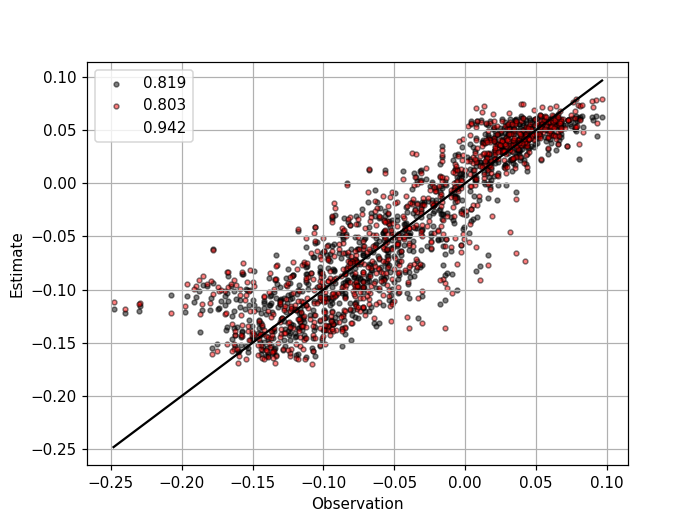

<IPython.core.display.Javascript object>


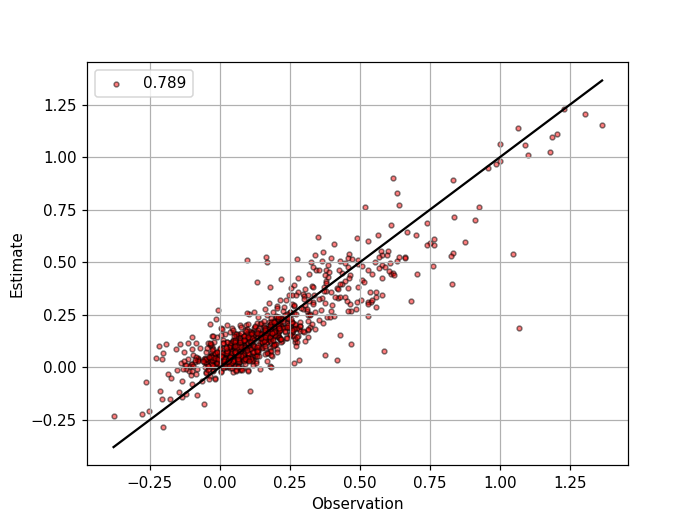

HR
0.0     0.050995
1.0     0.050173
2.0     0.042878
3.0     0.031052
4.0     0.012198
5.0    -0.013150
6.0    -0.038096
7.0    -0.071905
8.0    -0.087699
9.0    -0.096633
10.0   -0.110375
11.0   -0.111775
12.0   -0.111949
13.0   -0.111847
14.0   -0.104808
15.0   -0.086461
16.0   -0.073300
17.0   -0.054212
18.0   -0.038009
19.0   -0.008869
20.0    0.011712
21.0    0.036075
22.0    0.045140
23.0    0.053265
Name: NEE, dtype: float64
HR
0.0     0.006785
1.0     0.007414
2.0     0.006938
3.0     0.007189
4.0     0.009295
5.0     0.011898
6.0     0.015161
7.0     0.018891
8.0     0.019573
9.0     0.021559
10.0    0.019646
11.0    0.017177
12.0    0.016511
13.0    0.018683
14.0    0.018063
15.0    0.015462
16.0    0.013898
17.0    0.014921
18.0    0.013607
19.0    0.011171
20.0    0.009170
21.0    0.005973
22.0    0.005598
23.0    0.006118
Name: NEE, dtype: float64


In [45]:
plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NEE2','NEE3','NEE_est','fco2']].dropna()
LM = T30['fco2'].min(),T30['fco2'].max()
plt.plot(LM,LM,color='black')
plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fco2'],T30['NEE_est'],c='red',edgecolor='black',alpha=0,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)

plt.figure()
# plt.scatter(T30['PPFD_Avg'],T30['fco2'],c='red',edgecolor='black',alpha=.5,s=10)
Temp=T30[['NME_est','fch4']].dropna()
# print(T30[['NME_est','fch4']])
LM = T30['fch4'].min(),T30['fch4'].max()
plt.plot(LM,LM,color='black')
# plt.scatter(T30['fco2'],T30['NEE2'],c='black',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE2']),3)))
# plt.scatter(T30['fco2'],T30['NEE3'],c='red',edgecolor='black',alpha=.5,s=10,
#            label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE3']),3)))
plt.scatter(T30['fch4'],T30['NME_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fch4'],Temp['NME_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')
# plt.ylim(-1.9,1)
# plt.xlim(-1.9,1)

# print(fco2.Records)
print(T30.groupby('HR').mean()['NEE'])
print(T30.groupby('HR').std()['NEE']/28**.5*stats.t.ppf(1-.025,28))

In [28]:
def Plot(ax,Label,Data,regressor,color,target,Interval=None,linestyle='-',mult=1,alpha=None): 
    rgba = color.copy()
    if alpha is None:
        rgba[3]=.05
    else:
        rgba.append(alpha)
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    ax.plot(Data[regressor],Data[target]*mult,
            label= Label,
            linestyle=linestyle,
            linewidth=1.5,
            color = color)
    if Interval != None:
        ax.fill_between(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
                    facecolor = rgba,
                    edgecolor = color,
                    linestyle=':',
                    linewidth=1,
                   )

In [29]:

# Vars = ['VWC','Shrub','PPFD_Avg','AirTC_Avg']
# fig,ax = plt.subplots(4,1,figsize = (8,12))
# i,j=0,0
# plt.locator_params(nbins=10)
# for var in Vars:
#     T30[var].plot.hist(ax=ax[i],bins=15,edgecolor='k')
#     ax[i].set_title(var)
#     ax[i].grid()
# #     if j == 1:
# #         j -= 1
#     i += 1
# #     else:
# #         j += 1
# plt.tight_layout()
# print(
# print(T30['Upland'].mean())
# print(T30['Upland'].min())
# print(T30['Upland'].max())
T = T30.loc[T30['Shrub']<=T30['Shrub'].quantile(.05)]
print(T[['Grass','Sedge','Upland']].mean())

Grass     0.672302
Sedge     0.026604
Upland    0.051513
dtype: float64


In [30]:
import itertools
target = fco2#_interp
List = []
n = 25
Vars = []
print(target.Best['Model'])
for var in target.Best['Model'].values[0].split('+'):
    Vars.append(var)
#     List.append([T30[var].quantile(q/100) for q in range(0,101,10)])
    List.append(np.linspace(T30[var].min(),T30[var].max(),n))
Temp = pd.DataFrame(data=np.array(list(itertools.product(*List))),columns =Vars)
Temp[target.RST.params['target']]=0
target.RST.Data=Temp
# print(target.RST.Data)
# print(target.RST.params['target'])
target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
target.Map()

Temp = target.Data_Map

10    PPFD_Avg+AirTC_Avg+VWC
Name: Model, dtype: object
10


In [32]:

# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
# import matplotlib as mpl
# from matplotlib.ticker import LinearLocator, FormatStrFormatter
# %matplotlib notebook

# # Temp = target.Data_Map
# # print(Temp.head())
# a = 'PPFD_Avg'
# b = 'Shrub'
# x,y='VPD','VWC'
# z=target.target
# Select = Temp.loc[(np.abs(Temp[a]-T30[a].quantile(.99))==np.abs(Temp[a]-T30[a].quantile(.99)).min())&\
#                 (np.abs(Temp[b]-.4)==np.abs(Temp[b]-.4).min()),
#                 [x,y,z]
#                ]
# Sel1 = Select.loc[(np.abs(Select['VWC']-T30['VWC'].quantile(0))==np.abs(Select['VWC']-T30['VWC'].quantile(0)).min())]
# Sel2 = Select.loc[(np.abs(Select['VWC']-T30['VWC'].quantile(.5))==np.abs(Select['VWC']-T30['VWC'].quantile(.5)).min())]
# Sel3 = Select.loc[(np.abs(Select['VWC']-T30['VWC'].quantile(1))==np.abs(Select['VWC']-T30['VWC'].quantile(1)).min())]

# # print(Temp)
# # Select = Temp[[x,y,z]]
               

# # print(target.Data_Map.values.reshape(21,21,21,21,-1).shape)
# Select = Select.values.reshape(25,25,-1)
# X = Select[:,:,0]
# Y = Select[:,:,1]
# Z = Select [:,:,2]*mult[target.target]

# from matplotlib import colors
# norm = colors.DivergingNorm(vmin=-.01, vcenter=0., vmax=.01)

# fig = plt.figure()
# ax = fig.gca(projection='3d')


# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,#norm = norm,
#                        linewidth=0, antialiased=False)

# # Customize the z axis.
# # ax.set_zlim(-1.01, 1.01)
# # ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()
# # a=(Temp.loc[Temp['PPFD_Avg']==Temp['PPFD_Avg'].min()])
# # # print(a.loc[a['fco2']<0,['VWC','VPD','Shrub','fco2']].mean())
# # plt.figure()
# # plt.scatter(T30['AirTC_Avg'],T30['VPD'])
# plt.figure()
# plt.plot(Sel1['VPD'],Sel1[target.target],label='1')
# plt.plot(Sel2['VPD'],Sel2[target.target],label='2')
# plt.plot(Sel3['VPD'],Sel3[target.target],label='3')
# plt.legend()
# # print(Temp)

In [33]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def MapJobs(target,Range,N,Mask={},map_range=None):
#     print(target,Range,N,Mask,map_range)
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    try:
        scaler = StandardScaler()
        scaler.fit(target.RST.Data[columns[l:]])
        Temp = scaler.transform(target.RST.Data[columns[l:]])
        Temp = pd.DataFrame(data = Temp,columns = columns[l:])
        kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
        Q = scaler.inverse_transform(kmeans.cluster_centers_)
    except:
        Q = []
        for col in columns[1:]:
            Q.append(Mask[col])
        Q=np.asanyarray(Q).T
        print(Q)
        pass
    columns.append('target')
    def Make(Data,columns,map_range,values,C=20,Mask=None,i=0):
        ranges = [np.linspace(map_range[0],map_range[1],C)]
        for key in Mask.keys():
            ranges.append(np.ones(C)*Mask[key])
        for v in values:
            ranges.append(np.ones(C)*v)
        ranges.append(np.ones(C)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        data['key']=i
        
        return(pd.DataFrame(data = data))
    tarList=[]
    if map_range is None:
        map_range = [target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()]
    if len(Q) == 0:
        Data = Make(target.RST.Data,columns,
                    map_range=map_range,
                    values=[],Mask={key:item[i] for key, item in Mask.items()})
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
        if i == 0:
            Data = Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()})
        else:
            Data = Data.append(Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()},i=i))
#     print(Data)
    Data[target.RST.params['target']]=0
    target.RST.Data=Data
    target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
    target.Map()
    tarList.append(target.Data_Map)  
    return(tarList,Q,columns[1:-1],Data,target,Range)

In [38]:
Run = []
mult = {'fco2':(1e-6 * 12.0107 *3600),
        'ER':(1e-6 * 12.0107 *3600),
        'fch4':(1e-6 * 12.0107 *3600)}
target = fco2
differential = 'PPFD_Avg'
a,b,c='VWC','AirTC_Avg','Shrub'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.5),2),#np.round(T30[a].quantile(.5),2),
#       np.round(T30[a].quantile(.5),2),np.round(T30[a].quantile(.5),2),
      np.round(T30[a].quantile(.5),2),np.round(T30[a].quantile(.5),2),],
    b:[0,10,20],
#     c:[np.round(T30[c].quantile(.5),2), #np.round(T30[c].quantile(.5),2),
# #        np.round(T30[c].quantile(.5),2), np.round(T30[c].quantile(.5),2),
#        np.round(T30[c].quantile(.5),2), np.round(T30[c].quantile(.5),2)],
       }
map_range = [T30[differential].quantile(0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))

target = fco2
differential = 'VWC'
a,b,c='AirTC_Avg','PPFD_Avg','Shrub'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.225),2),#np.round(T30[a].quantile(.5),2),
      np.round(T30[a].quantile(.225),2),np.round(T30[a].quantile(.225),2)],
    b:[T30[b].quantile(.2),#T30[b].quantile(0),
       T30[b].quantile(.5),T30[b].quantile(.8)],
#     c:[np.round(0,2),# np.round(T30[c].quantile(.35),2),
#       np.round(T30[c].quantile(.5),2), np.round(1,2)]
       }
map_range = [T30[differential].quantile(0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))

# target = fco2
# differential = 'VWC'
# a,b,c='VPD','PPFD_Avg','Shrub'
# N = 3
# Mask = {
#     a:[np.round(T30[a].quantile(.5),2),#np.round(T30[a].quantile(.5),2),
#       np.round(T30[a].quantile(.5),2),np.round(T30[a].quantile(.5),2)],
#     b:[T30[b].quantile(.5),#T30[b].quantile(0),
#        T30[b].quantile(.5),T30[b].quantile(.5)],
#     c:[np.round(T30[c].quantile(.05),2),# np.round(T30[c].quantile(.35),2),
#       np.round(T30[c].quantile(.5),2), np.round(T30[c].quantile(.95),2)]
#        }
# map_range = [T30[differential].quantile(0),T30[differential].quantile(1)]
# Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))

target = fco2
differential = 'VWC'
a,b,c='AirTC_Avg','PPFD_Avg','Shrub'
N = 3
Mask = {
    a:[np.round(T30[a].quantile(.25),2),#np.round(T30[a].quantile(.5),2),
      np.round(T30[a].quantile(.25),2),np.round(T30[a].quantile(.25),2)],
    b:[T30[b].quantile(0),#T30[b].quantile(0),
       T30[b].quantile(0),T30[b].quantile(0)],
#     c:[np.round(0,2),# np.round(T30[c].quantile(.35),2),
#       np.round(T30[c].quantile(.5),2), np.round(1,2)]
       }
map_range = [T30[differential].quantile(0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))


[[ 0.54  0.  ]
 [ 0.54 10.  ]
 [ 0.54 20.  ]]
10
[[  4.43        22.19766667]
 [  4.43       211.75833333]
 [  4.43       627.03666667]]
10
[[4.64  1.757]
 [4.64  1.757]
 [4.64  1.757]]
10


<IPython.core.display.Javascript object>


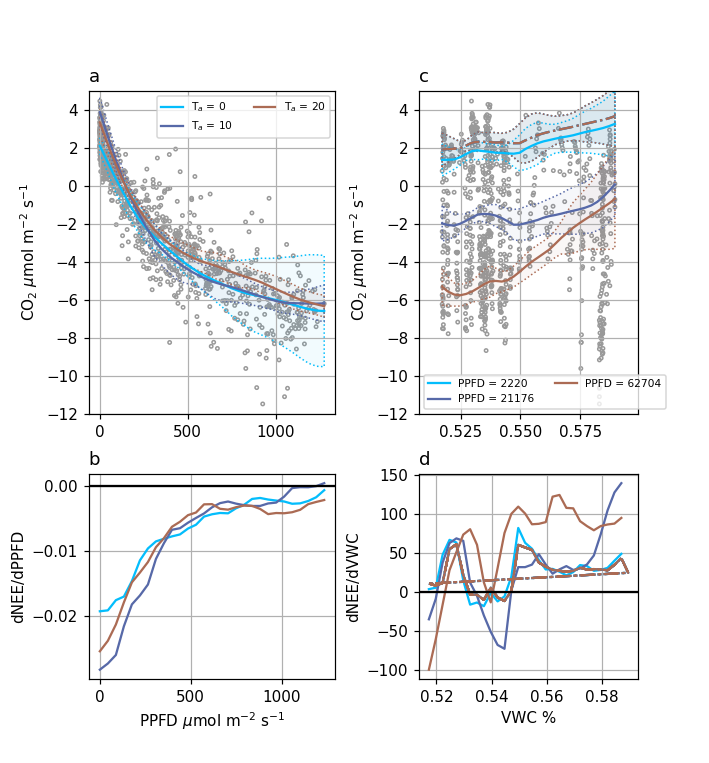

[[ 0.54  0.  ]
 [ 0.54 10.  ]
 [ 0.54 20.  ]] ['VWC', 'AirTC_Avg']
[[  4.43        22.19766667]
 [  4.43       211.75833333]
 [  4.43       627.03666667]] ['AirTC_Avg', 'PPFD_Avg']
[[4.64  1.757]
 [4.64  1.757]
 [4.64  1.757]] ['AirTC_Avg', 'PPFD_Avg']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


In [39]:
%matplotlib notebook
fig = plt.figure(figsize=(6.5,7))

# xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
# colors = [[1,0,0],[1,.0,0],[0,0,1],[0,0,1],[0,0,0],[0,.0,0],[0,1,0],[0,1,0]]
# colors = [[0,0,1,.75],[.0,0,.5,.75],[.5,0,.0,.75],[1,0,0,.75],[0,0,1,.75],[.25,0,.5,.75],[.5,0,.25,.75],[1,0,0,.75]]


# lines = ['-.','-','-.','-','-.','-','-.','-']
lines = ['-','-','-.',':','--']#,'-.','-.','-.','-.']
lbls = ['AirTC_Avg','PPFD_Avg']

# lbla = 'VPD'
# lblb = 'Shrub'
ab = [[1,100],[100,1]]
# a=1
# b=100
# xlb = xlbs[0]
RunAlt = []
# for i in [0,3,4]:
#     RunAlt.append(Run[i])
ax = []
ax.append(plt.subplot2grid((100, 100), (0, 0),  rowspan=55,colspan=45))
ax.append(plt.subplot2grid((100, 100), (65, 0), rowspan=35,colspan=45))
ax.append(plt.subplot2grid((100, 100), (0, 60), rowspan=55,colspan=40))
ax.append(plt.subplot2grid((100, 100), (65, 60),rowspan=35,colspan=40))
l = 1
for k in range(3):
    tarList,means,columns,Data,target,differential = Run[k]
    print(means,columns)
    n = means.shape[0]
    colors = []
    for x in range(1,100,int(100/n)):
        colors.append([x/100,(np.abs(x-50)+25)/100,(100-x)/100])
    if k >1:
        l += 1
        k = 1
    lbla=lbls[k]
    a,b = ab[k]
    SCENARIOS = []
    cols = [aliases[col] for col in columns]
    Scenarios = pd.DataFrame(data=means,columns=cols)
    Scenarios = Scenarios.round(2)
    SCENARIOS.append(Scenarios)
    AllData=tarList[0]
#     AllData[target.target]/=mult[target.target]
#     if target == ER:
# #         line = ':'
#     else:
#         line = '-'
    line = lines[l]
    if l < 2:
        ax[k*2].scatter(T30[differential],T30[target.target]/mult[target.target]*2,edgecolor=[.6,.6,.6],
                    facecolor='None',s=5)
    j = 0
    for key,color in zip(AllData['key'].unique(),colors):
        label = aliases[lbla]+' = '+str(int(Scenarios[aliases[lbla]].iloc[j]*a))# +' '+\
#         aliases[lblb]+' = '+str(int(Scenarios[aliases[lblb]].iloc[j]*b))
        if l > 1:
            label = None
        AllData['Select']=0
        for i,col in enumerate(columns):
            AllData.loc[np.abs(AllData[col]-means[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Plot(ax[k*2],label,Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1,alpha = .05)
        ax[k*2+1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*1)[1:],
               linestyle = line,label = label,color = color)
        j+=1
    ax[k*2].legend(fontsize = 7,loc=0,ncol=2)
    k = l
ax[0].set_ylim(-12,5)
ax[2].set_ylim(-12,5)
ax[1].axhline(y=0, xmin=0, xmax=1,color='k')
ax[3].axhline(y=0, xmin=0, xmax=1,color='k')
ax[0].set_ylabel('CO$_{2}$ ${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[2].set_ylabel('CO$_{2}$ ${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[1].set_xlabel('PPFD ${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[3].set_xlabel('VWC %')
ax[1].set_ylabel('dNEE/dPPFD')
ax[3].set_ylabel('dNEE/dVWC')
ax[0].set_title('a',loc='left')
ax[2].set_title('c',loc='left')
ax[1].set_title('b',loc='left')
ax[3].set_title('d',loc='left')
for axes in ax:
    axes.grid()
#     print(label)
#     j += 1
#     print('Light Use')
#     print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
#           np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])

#     print('Intercept')
#     print(Data[target.target].iloc[0]*mult[target.target])
# print(Scenarios)
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig4.png',dpi=300)

In [36]:
Run = []
target = fch4
print(target.Best)
# val = target.target
differential = 'VWC'
a,b,c,d='AirTC_Avg','Grass','wind_speed','Sedge'
N = 3
Mask = {
    a:[np.round(10,2) for n in range(N)],
    b:[np.round(T30[b].quantile(n/N),2) for n in range(N)],
    c:[1,T30[c].mean(),0],
#     c:[np.round(T30[c].quantile(.0),2),np.round(T30[c].quantile(.50),2), np.round(T30[c].quantile(1),2)],
#     d:[np.round(.25,2) for n in range(N)],
    
    d:[np.round(T30[b].quantile((N-n)/N),2) for n in range(N)],
#     e:[0,T30[e].mean(),1]
#     e:[np.round(T30[e].quantile(1),2), np.round(T30[e].quantile(.5),2), np.round(T30[e].quantile(0),2)]
       }
map_range = [T30[differential].quantile(.0),T30[differential].quantile(1)]
# print(target,differential,N,Mask,map_range)
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))


target = fch4
print(target.Best)
# val = target.target
differential = 'AirTC_Avg'
a,b,c,d='VWC','Grass','wind_speed','Sedge'
N = 3
Mask = {
    a:[np.round(0.55,2) for n in range(N)],
    b:[np.round(T30[b].quantile(.4),2) for n in range(N)],
#     c:[1,T30[c].mean(),0],
    c:[np.round(T30[c].quantile(.0),2),np.round(T30[c].quantile(.50),2), np.round(T30[c].quantile(1),2)],
    d:[np.round(0.25,2) for n in range(N)],
#     e:[0,T30[e].mean(),1]
#     e:[np.round(T30[e].quantile(1),2), np.round(T30[e].quantile(.5),2), np.round(T30[e].quantile(0),2)]
       }
map_range = [T30[differential].quantile(.0),T30[differential].quantile(1)]
Run.append(MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range))

                                   Model        MSE  Size  Number  \
19  AirTC_Avg+wind_speed+VWC+Sedge+Grass  35.463675     5       2   

    HiddenNodes        SE        r2  Performance   K    Thresh Model_Key  \
19           73  5.740084  0.687353            1  10  41.20376       5_2   

        RMSE  T2  Select  
19  5.955139   0       1  
[[10.          0.01        1.          0.78      ]
 [10.          0.19        3.86858795  0.52      ]
 [10.          0.52        0.          0.19      ]]
10
                                   Model        MSE  Size  Number  \
19  AirTC_Avg+wind_speed+VWC+Sedge+Grass  35.463675     5       2   

    HiddenNodes        SE        r2  Performance   K    Thresh Model_Key  \
19           73  5.740084  0.687353            1  10  41.20376       5_2   

        RMSE  T2  Select  
19  5.955139   0       1  
[[ 0.55  0.25  0.22  0.25]
 [ 0.55  0.25  3.44  0.25]
 [ 0.55  0.25 11.11  0.25]]
10


<IPython.core.display.Javascript object>


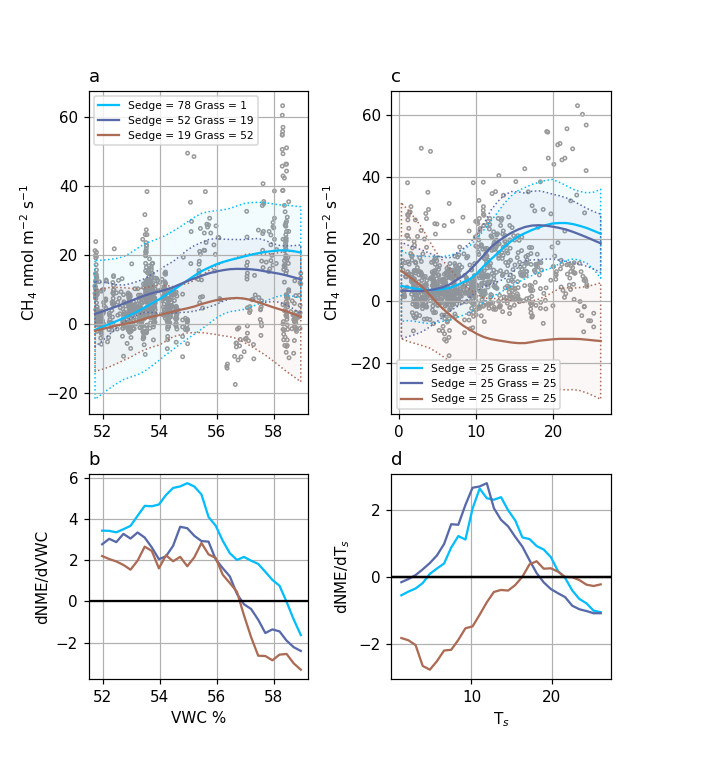

[[10.          0.01        1.          0.78      ]
 [10.          0.19        3.86858795  0.52      ]
 [10.          0.52        0.          0.19      ]] ['AirTC_Avg', 'Grass', 'wind_speed', 'Sedge']
[[ 0.55  0.25  0.22  0.25]
 [ 0.55  0.25  3.44  0.25]
 [ 0.55  0.25 11.11  0.25]] ['VWC', 'Grass', 'wind_speed', 'Sedge']


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


In [37]:
%matplotlib notebook
fig = plt.figure(figsize=(6.5,7))
lbls = [['Sedge','Grass'],['Sedge','Grass']]
# lbla = 'VPD'
# lblb = 'Shrub'
ab = [[100,100],[100,100]]
# a=1
# b=100
# xlb = xlbs[0]
ax = []
ax.append(plt.subplot2grid((100, 100), (0, 0),  rowspan=55,colspan=40))
ax.append(plt.subplot2grid((100, 100), (65, 0), rowspan=35,colspan=40))
ax.append(plt.subplot2grid((100, 100), (0, 55), rowspan=55,colspan=40))
ax.append(plt.subplot2grid((100, 100), (65, 55),rowspan=35,colspan=40))
for k in range(2):
    tarList,means,columns,Data,target,differential = Run[k]
    print(means,columns)
    n = means.shape[0]
    colors = []
    for x in range(1,100,int(100/n)):
        colors.append([x/100,(np.abs(x-50)+25)/100,(100-x)/100])
    if k >1:
        k = 1
    lbla,lblb=lbls[k][0],lbls[k][1]
    a,b = ab[k]
    SCENARIOS = []
    cols = [aliases[col] for col in columns]
    Scenarios = pd.DataFrame(data=means,columns=cols)
    Scenarios = Scenarios.round(2)
    SCENARIOS.append(Scenarios)
    AllData=tarList[0]
    if AllData['VWC'].max()<1:
        AllData['VWC']*=100
#     if target == ER:
#         line = ':'
#     else:
    line = '-'
    m = 1
    if differential == 'VWC':
        m = 100
    ax[k*2].scatter(T30[differential]*m,T30[target.target]/mult[target.target]*2,edgecolor=[.6,.6,.6],
                facecolor='None',s=5)
    j = 0
    for key,color in zip(AllData['key'].unique(),colors):
        label = aliases[lbla]+' = '+str(int(Scenarios[aliases[lbla]].iloc[j]*a)) +' '+\
        aliases[lblb]+' = '+str(int(Scenarios[aliases[lblb]].iloc[j]*b))
#         if target == ER:
#             label = None
        AllData['Select']=0
        for i,col in enumerate(columns):
            AllData.loc[np.abs(AllData[col]-means[key,i])<1e-4,'Select']+=1
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Plot(ax[k*2],label,Data,differential,color,target.target,Interval = 'CI',
             linestyle=line,mult=1,alpha = .05)
        ax[k*2+1].plot(Data[differential],(Data[target.target].diff()/Data[differential].diff()),
               linestyle = line,label = label,color = color)
        j+=1
    ax[k*2].legend(fontsize = 7,loc=0,ncol=1)
ax[0].set_xlim(51.5,59.2)
ax[1].set_xlim(51.5,59.2)
ax[3].axhline(y=0, xmin=0, xmax=1,color='k')

# ax[0].set_ylim(-10,50)
# ax[2].set_ylim(-10,50)
ax[1].axhline(y=0, xmin=0, xmax=1,color='k')
ax[3].axhline(y=0, xmin=0, xmax=1,color='k')
ax[0].set_ylabel('CH$_{4}$ nmol m$^{-2}$ s$^{-1}$')
ax[2].set_ylabel('CH$_{4}$ nmol m$^{-2}$ s$^{-1}$')
ax[1].set_xlabel('VWC %')
ax[3].set_xlabel('T$_s$')
ax[1].set_ylabel('dNME/dVWC')
ax[3].set_ylabel('dNME/dT$_s$')
ax[0].set_title('a',loc='left')
ax[2].set_title('c',loc='left')
ax[1].set_title('b',loc='left')
ax[3].set_title('d',loc='left')
for axes in ax:
    axes.grid()
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig5.png',dpi=300)

In [ ]:
# print(T30['wind_speed'].quantile(.0))
# print(T30['VPD'].quantile(.05))
# print(List)#-T30[c].quantile(0))
fig,ax = plt.subplots(6,1,figsize = (8,15))
i,j=0,0
plt.locator_params(nbins=10)
for var in Vars:
    T30[var].plot.hist(ax=ax[i],bins=15,edgecolor='k')
    ax[i].set_title(var)
    ax[i].grid()
#     if j == 1:
#         j -= 1
    i += 1
#     else:
#         j += 1
plt.tight_layout()
print(Vars)

In [392]:
print(target.RST.params['Inputs'])
target = fch4
# List = []
# n = 3
# Exclude = ['wind_speed','VPD']
Vars = ['VWC','Temp','Sedge','Shrub','wind_speed']
List = [[.5,.53,.55,.58,.6],
        [3,7,12],
        [0,.05,.1,.25,.5,1],
        [0,.1,.25,.4,.6,1],
        np.linspace(T30['wind_speed'].min(),T30['wind_speed'].max(),10),
#         np.linspace(T30['VPD'].min(),T30['VPD'].max(),10),
]
print(List)
Temp = pd.DataFrame(data=np.array(list(itertools.product(*List))),columns=Vars)
target.RST.Data=Temp
target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
target.Map()

['PPFD_Avg', 'VPD', 'VWC', 'Shrub']
[[0.5, 0.53, 0.55, 0.58, 0.6], [3, 7, 12], [0, 0.05, 0.1, 0.25, 0.5, 1], [0, 0.1, 0.25, 0.4, 0.6, 1], array([ 0.21797055,  1.4287399 ,  2.63950925,  3.85027861,  5.06104796,
        6.27181732,  7.48258667,  8.69335602,  9.90412538, 11.11489473])]


<IPython.core.display.Javascript object>


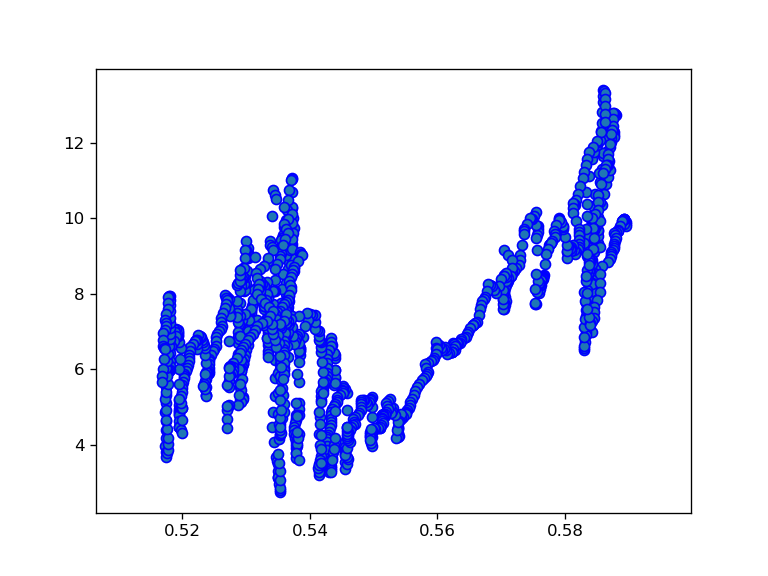

(0.5614630159319692, 8.303737925465192e-107)
       VWC  wind_speed       fch4         CI
620   0.50    0.217971  -1.922638   6.239820
621   0.50    1.428740  -2.426219   6.424721
622   0.50    2.639509  -2.312543   6.992248
623   0.50    3.850279  -1.907810   7.001139
624   0.50    5.061048  -0.925045   6.609655
625   0.50    6.271817   0.622274   6.575542
626   0.50    7.482587   2.268339   6.603663
627   0.50    8.693356   4.083997   6.752085
628   0.50    9.904125   5.946123   7.298782
629   0.50   11.114895   7.732225   8.140709
1700  0.53    0.217971   9.114671   4.550570
1701  0.53    1.428740   7.076680   3.967910
1702  0.53    2.639509   4.975114   3.891328
1703  0.53    3.850279   3.630373   3.119127
1704  0.53    5.061048   3.692335   2.148284
1705  0.53    6.271817   4.952730   2.291024
1706  0.53    7.482587   6.824964   3.559396
1707  0.53    8.693356   8.698419   5.574485
1708  0.53    9.904125  10.402239   7.499591
1709  0.53   11.114895  11.861603   9.107974
2780  0.55

<IPython.core.display.Javascript object>


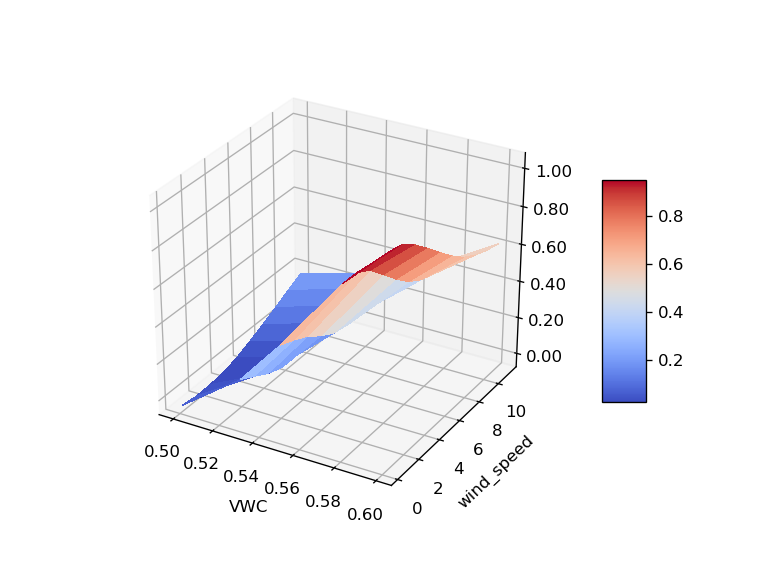

In [398]:
plt.figure()
plt.scatter(T30['VWC'],T30['Temp'],marker='o',facecolor=None,edgecolor='b')
Temp = T30[['VWC','Temp']].dropna()
# print(metrics.r2_score(Temp['VWC'],Temp['Temp']))
from scipy.stats import pearsonr
res = pearsonr(Temp['VWC'],Temp['Temp'],)
print(res)

# fig,ax = plt.subplots(2,1,figsize=(10,10))
# for s,line in zip([1,0],[':','-']):
Temp = target.Data_Map
a = 'Shrub'
b = 'Sedge'
c = 'Temp'
# d = 'VWC'
x,y='VWC','wind_speed'
z=target.target
Selection = Temp.loc[(np.abs(Temp[a]-.2)==np.abs(Temp[a]-.2).min())&\
                    (np.abs(Temp[b]-.5)==np.abs(Temp[b]-.5).min())&\
                    (np.abs(Temp[c]-7)==np.abs(Temp[c]-7).min()),
#                     (np.abs(Temp[d]-.55)==np.abs(Temp[d]-.55).min()),
                    [x,y,z,'CI']
               ]
print(Selection)
Select = Selection.values.reshape(5,10,-1)
print(Select.shape)

# print(Temp)
X = Select[:,:,0]
Y = Select[:,:,1]
Z = Select [:,:,2]*mult[target.target]

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(x)
ax.set_ylabel(y)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [308]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# steps = [.53,.55,.58]
# steps = [0,.1,.4,.8,]
# for i,q in enumerate(steps):
#     color = [0,.5,0]
#     color[0]=1-i/len(steps)
#     color[2]=0+i/len(steps)
# #     x = c
#     nu = Selection.loc[(np.abs(Selection[y]-q)==np.abs(Selection[y]-q).min())]
#     rgba = color.copy()
#     rgba.append(.025)
#     ax[0].plot(nu[x],nu[target.target]*mult[target.target],color = color,linestyle=line,
#               label=q)#,style=line)
#     print(color)
#     ax[0].fill_between(nu[x],
#                     mult[target.target]*(nu[target.target]-nu['CI']), 
#                     mult[target.target]*(nu[target.target]+nu['CI']),
#                     facecolor = rgba,edgecolor = color,linestyle=':',linewidth=1,
#                    )
#     ax[1].plot(nu[x][:-1],(nu[target.target].diff()/nu[x].diff()*mult[target.target])[1:],
#            color = color,linestyle=line)
#     ax[0].grid()
#     ax[1].grid()
#     ax[0].legend()
#Select.loc(np.abs(Select['Sedge']-Select['Sedge'].quantile(.5))np.abs(Select['Sedge']-Select['Sedge'].quantile(.5))))

          VPD  wind_speed       fch4         CI
38175     0.0        0.25   6.450717   3.235257
38176   125.0        0.25   7.948732   3.170672
38177   300.0        0.25  10.045534   4.379187
38178   500.0        0.25  12.355638   6.351639
38179  1000.0        0.25  17.450802  10.225949
38180     0.0        1.00   5.695775   2.960278
38181   125.0        1.00   7.293370   2.687827
38182   300.0        1.00   9.535268   3.628703
38183   500.0        1.00  12.155072   5.505811
38184  1000.0        1.00  17.022556   8.955171
38185     0.0        3.00   3.838567   3.148785
38186   125.0        3.00   5.433585   2.502737
38187   300.0        3.00   8.210590   2.129387
38188   500.0        3.00  11.567448   2.504481
38189  1000.0        3.00  15.401339   5.464147
38190     0.0        6.00   8.114866   3.850176
38191   125.0        6.00  10.041994   3.376788
38192   300.0        6.00  12.278050   3.944090
38193   500.0        6.00  13.235734   5.057585
38194  1000.0        6.00  13.751230   7

ValueError: cannot reshape array of size 100 into shape (11,11,newaxis)

In [ ]:
print(Scenarios)
print(Mask)

In [ ]:
fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid((100, 100), (0, 0),rowspan=55,colspan=45)
ax2 = plt.subplot2grid((100, 100), (65, 0),rowspan=35,colspan=45)
ax3 = plt.subplot2grid((100, 100), (0, 60),rowspan=55,colspan=40)
ax4 = plt.subplot2grid((100, 100), (65, 60),rowspan=35,colspan=40)


mult = {'fco2':(1e-6 * 12.0107 *3600),
        'ER':(1e-6 * 12.0107 *3600),
        'fch4':(1e-3 * 12.0107 *3600)}

differential = 'PPFD_Avg'
a,b,c,d='VPD','VWC','Sedge','Shrub'
N = 2
Mask = {
    a:[200,1000],
#     b:[.58,.28,.58,.52],
#     a:[np.round(T30[a].mean(),2) for n in range(N)],
    b:[np.round(T30[b].mean(),2) for n in range(N)],
    c:[np.round(T30[c].mean(),2) for n in range(N)],
    d:[np.round(T30[d].mean(),2) for n in range(N)],
       }
map_range = [T30[differential].min(),T30[differential].max()]
# xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
colors = [[1,0,0],[0,0,1],[1,.0,0],[0,0,1]]
lines = ['-.','-.','-','-']
target = fco2
# xlb = xlbs[0]
FirstRun = True
# FirstRun = False
if FirstRun == True:
    Run = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
         Mask=Mask,map_range=map_range)
    Run.append([tarList_co2,means_co2,columns_co2,Data_co2])
else:
    tarList_co2,means_co2,columns_co2,Data_co2 = Run[0]
SCENARIOS = []
cols = [aliases[col] for col in columns_co2]
Scenarios = pd.DataFrame(data=means_co2,columns=cols)
Scenarios = Scenarios.round(2)
SCENARIOS.append(Scenarios)
AllData=tarList_co2[0]
if target == ER:
    val = 'ER'
else:
    val = 'fco2'
# ax1.scatter(target.RST.Master[differential],target.RST.Master[val]*mult[target.target],
#           edgecolor=[.6,.6,.6],facecolor='None',s=10,label = 'Obs.')
ax1.scatter(T30[differential],T30['fco2']*2,
          edgecolor=[1,.6,.6],facecolor='None',s=10,label = 'Obs.')
j = 0
for key,color,line in zip(AllData['key'].unique(),colors,lines):
    label = aliases[a]+' = '+str(int(Scenarios[aliases[a]].iloc[j]*100))
    AllData['Select']=0
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
    Plot(ax1,label,Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=mult[target.target],alpha=.05)
#     tar = 'F$_{CO2}$'

    ax2.plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
           linestyle = line,label = label,color = color)
#     print(label)
#     j += 1
#     print('Light Use')
#     print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
#           np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])

#     print('Intercept')
#     print(Data[target.target].iloc[0]*mult[target.target])


In [ ]:
%matplotlib notebook
mult = {'fco2':(1e-6 * 12.0107 *3600),
        'ER':(1e-6 * 12.0107 *3600),
        'fch4':(1e-3 * 12.0107 *3600)}
# line = '-'
# colors = [[0,0,0]]
# N=len(colors)
FirstRun = True
# FirstRun = False
# fco2.Model_Selection = 'PPFD_Avg'

# differential='PPFD_Avg'
# map_range=[T30[differential].min(),T30[differential].max()]
# if FirstRun == True:
#     Just = []
#     tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,differential,N=N,map_range=map_range)
#     Just.append([tarList_co2,means_co2,columns_co2,Data_co2])
# else:
#     tarList_co2,means_co2,columns_co2,Data_co2 = Just[0]
# AllData=tarList_co2[0]
# target = fco2
fig = plt.figure(figsize=(6.5,7))
ax1 = plt.subplot2grid((100, 100), (0, 0),rowspan=55,colspan=45)
ax2 = plt.subplot2grid((100, 100), (65, 0),rowspan=35,colspan=45)
ax3 = plt.subplot2grid((100, 100), (0, 60),rowspan=55,colspan=40)
ax4 = plt.subplot2grid((100, 100), (65, 60),rowspan=35,colspan=40)
# j = 0
# idx = []
ax = [ax1,ax2]
# # colorz = []

# for key,color in zip(AllData['key'].unique(),colors):
#     AllData['Select']=0
#     label = 'PPFD Alone'
#     for i,col in enumerate(columns_co2):
#         AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
#     Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
# #     Data[target.target] -= Data[target.target].iloc[0]
# #     Data[target.target] *=-1
#     Plot(ax[0],label,
#          Data,differential,color,target.target,Interval = 'CI',
#          linestyle=line,mult=mult[target.target])
#     tar = 'fco2'
#     ax[1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
#            linestyle = line,label = label,color = color)
#     ax[1].axes.ticklabel_format(axis='x',style='sci')
#     j += 1
#     print('LightUse')
#     print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
#           np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])
#     print('Intercept')
#     print(Data[target.target].iloc[0]*mult[target.target])

fco2.Model_Selection = 'PPFD_Avg+VWC+Out_of_Basin'#'PPFD_Avg+VPD+VWC+Shrub'
N = 4
QV = 'VWC'
Mask = {'Out_of_Basin':[0,1,0,1],#[T30['Out_of_Basin'].min(),T30['Out_of_Basin'].max(),
#                         T30['Out_of_Basin'].min(),T30['Out_of_Basin'].max()],# for n in range(N)],#
#            'VWC':np.asanyarray([T30['VWC'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           QV:np.asanyarray([T30[QV].quantile(.05),T30[QV].quantile(.05),
                             T30[QV].quantile(.95),T30[QV].quantile(.95)]),
           }
differential = 'PPFD_Avg'
map_range = [T30[differential].min(),T30[differential].max()]
print(map_range)
SCENARIOS = []
xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
colors = [[1,0,0],[0,0,1],[1,.0,0],[0,0,1]]
lines = ['-.','-.','-','-']
target = fco2
xlb = xlbs[0]
# FirstRun == False
if FirstRun == True:
    CO21 = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,
         Mask=Mask,map_range=map_range)
    CO21.append([tarList_co2,means_co2,columns_co2,Data_co2])
else:
    tarList_co2,means_co2,columns_co2,Data_co2 = CO21[0]
    print(means_co2,columns_co2)
    
AllData=tarList_co2[0]
# colorz = []
if target == ER:
    val = 'ER'
else:
    val = 'fco2'
ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*mult[target.target],
          edgecolor=[.6,.6,.6],
          facecolor='None',s=10,label = 'Obs.')
cols = [aliases[col] for col in columns_co2]
Scenarios = pd.DataFrame(data=means_co2,columns=cols)
Scenarios = Scenarios.round(2)
# print(Scenarios)
SCENARIOS.append(Scenarios)
j = 0
for key,color,line in zip(AllData['key'].unique(),colors,lines):
    List = [color]
    List+=['white'for i in range(len(columns_co2))]
#     colorz.append(List)
    AllData['Select']=0
#     print(key)
    label = aliases[QV]+' = '+str(int(Scenarios[aliases[QV]].iloc[j]*100))+' Pa'
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
#     Data[target.target] -= Data[target.target].iloc[0]
#     Data[target.target] *= -1
    Plot(ax[0],label,
         Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=mult[target.target],alpha=.05)
    tar = 'F$_{CO2}$'

    ax[1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
           linestyle = line,label = label,color = color)
#     print(label)
    j += 1
    print('Light Use')
    print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
          np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])

    print('Intercept')
    print(Data[target.target].iloc[0]*mult[target.target])

    
ax = [ax3,ax4]
plt.show()

target = ER

N = 3
QV = 'Out_of_Basin'
# QV2 = 'VWC'
Mask = {'Out_of_Basin':np.asanyarray([0,T30['Out_of_Basin'].mean(),1]),#T30['Out_of_Basin'].mean() for n in range(N)]),
#     'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(N)]),#
#     'VWC':np.asanyarray([T30['VWC'].quantile(.15),T30['VWC'].quantile(.85)]),
    'PPFD_Avg':np.asanyarray([0,0,0]),
           }
SCENARIOS = []
# xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
differential='VWC'
map_range = [T30[differential].min(),T30[differential].max()]
# N=2
colors = [[1,0,0],[0,0,1],[1,0,0],[0,0,1]]
lines = ['-','-',':',':']
target = fco2
xlb = xlbs[0]
if FirstRun == True:
    CO212 = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range)
    CO212.append([tarList_co2,means_co2,columns_co2,Data_co2])
else:
    tarList_co2,means_co2,columns_co2,Data_co2 = CO212[0]
    
print(CO212)
    
AllData=tarList_co2[0]
colorz = []
if target == ER:
    val = 'ER'
else:
    val = 'fco2'
cols = [aliases[col] for col in columns_co2]
Scenarios = pd.DataFrame(data=means_co2,columns=cols)
Scenarios = Scenarios.round(2)
# print(Scenarios)
SCENARIOS.append(Scenarios)
j = 0
ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*mult[target.target],
              edgecolor=[.6,.6,.6],facecolor='None',s=10,label = 'Obs.')
for key,color,line in zip(AllData['key'].unique(),colors,lines):
    List = [color]
    List+=['white'for i in range(len(columns_co2))]
    colorz.append(List)
    AllData['Select']=0
#     print(key)
    label = aliases[QV]+' = '+str(int(Scenarios[aliases[QV]].iloc[j]*100))#+','+ aliases[QV2]+' = '+str(int(Scenarios[aliases[QV2]].iloc[j]*100))
    for i,col in enumerate(columns_co2):
        AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
    Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
    Plot(ax[0],label,Data,differential,color,target.target,Interval = 'CI',
         linestyle=line,mult=mult[target.target],alpha=.05)
    tar = 'F$_{CO2}$'

    ax[1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
           linestyle = line,label = label,color = color)
    j += 1
    print('Light Use')
    print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
          np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])

    print('Intercept')
    print(Data[target.target].iloc[0]*mult[target.target])



# target = fco2
# N = 3
# QV = 'Out_of_Basin'
# # QV2 = 'VWC'
# Mask = {'Out_of_Basin':np.asanyarray([0,T30['Out_of_Basin'].mean(),1]),#T30['Out_of_Basin'].mean() for n in range(N)]),
# #     'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(N)]),#
# #     'VWC':np.asanyarray([T30['VWC'].quantile(.15),T30['VWC'].quantile(.85)]),
#     QV:np.asanyarray([1000,1000,1000])
#        }
# SCENARIOS = []
# # xlbs = [' ${\mu}$mol m$^{-2}$ s$^{-2}$',' Pa']
# # differential='VPD'
# map_range = [T30[differential].min(),T30[differential].max()]
# # N=2
# colors = [[1,0,0],[0,0,1],[1,0,0],[0,0,1]]
# lines = ['-','-',':',':']
# target = fco2
# xlb = xlbs[0]
# if FirstRun == True:
#     CO213 = []
#     tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(target,differential,N=N,Mask=Mask,map_range=map_range)
#     CO213.append([tarList_co2,means_co2,columns_co2,Data_co2])
# else:
#     tarList_co2,means_co2,columns_co2,Data_co2 = CO213[0]
    
# AllData=tarList_co2[0]
# colorz = []
# if target == ER:
#     val = 'ER'
# else:
#     val = 'fco2'
# cols = [aliases[col] for col in columns_co2]
# Scenarios = pd.DataFrame(data=means_co2,columns=cols)
# Scenarios = Scenarios.round(2)
# # print(Scenarios)
# SCENARIOS.append(Scenarios)
# j = 0
# ax[0].scatter(target.RST.Master[differential],target.RST.Master[val]*mult[target.target],
#               edgecolor=[.6,.6,.6],facecolor='None',s=10,label = 'Obs.')
# for key,color,line in zip(AllData['key'].unique(),colors,lines):
#     List = [color]
#     List+=['white'for i in range(len(columns_co2))]
#     colorz.append(List)
#     AllData['Select']=0
# #     print(key)
#     label = aliases[QV]+' = '+str(int(Scenarios[aliases[QV]].iloc[j]*100))#+','+ aliases[QV2]+' = '+str(int(Scenarios[aliases[QV2]].iloc[j]*100))
#     for i,col in enumerate(columns_co2):
#         AllData.loc[np.abs(AllData[col]-means_co2[key,i])<1e-4,'Select']+=1
#     Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
#     Plot(ax[0],label,Data,differential,color,target.target,Interval = 'CI',
#          linestyle=line,mult=mult[target.target],alpha=.05)
#     tar = 'F$_{CO2}$'

#     ax[1].plot(Data[differential][:-1],(Data[target.target].diff()/Data[differential].diff()*mult[target.target])[1:],
#            linestyle = line,label = label,color = color)
#     j += 1
#     print('Light Use')
#     print(np.min(Data[target.target].diff()/Data[differential].diff())*mult[target.target],
#           np.max(Data[target.target].diff()/Data[differential].diff())*mult[target.target])

#     print('Intercept')
#     print(Data[target.target].iloc[0]*mult[target.target])
    
# ax3.legend(fontsize=9,loc=0)
ax3.set_ylim(-.36,.2)
ax3.grid()
# ax3.set_xlim(0,T30['PPFD_Avg'].max())
# ax3.set_xlabel(aliases[differential]+' %')
ax3.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax3.set_title('c.',loc='left')

ax4.ticklabel_format(axis='y',style='sci',scilimits = (0,0))
ax4.get_yaxis().get_offset_text().set_position((-0.2,-0.1))
ax4.grid()
# ax4.set_xlim(0,T30['PPFD_Avg'].max())
ax4.set_ylabel('d'+tar+'/d'+aliases[differential])
ax4.set_xlabel(aliases[differential]+' Pa')
ax4.legend(fontsize=9,loc=0)
ax4.set_title('d.',loc='left')

ax2.legend(fontsize=9,loc=4)
ax1.set_title('a.',loc='left')
ax1.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax1.grid()
ax2.set_ylabel('$\\alpha$')
ax2.ticklabel_format(axis='y',style='sci',scilimits = (0,0))
ax2.get_yaxis().get_offset_text().set_position((-0.2,-0.1))
ax2.set_title('b.',loc='left')
ax2.grid()
ax2.set_xlabel('PPFD ${\mu}$mol m$^{-2}$ s$^{-2}$')


ax1.set_ylim(-.35,.23)
ax3.set_ylim(-.35,.23)
        
# plt.tight_layout()

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig5.png',dpi=300)


In [ ]:
print(means_co2,cols)
print(target,differential,N,
         Mask,map_range)
# print(tarList_co2,means_co2,columns_co2,Data_co2)


In [ ]:
# FirstRun=True
FirstRun=False
target = fco2
if FirstRun == True:  
    CO22A = []

fig = plt.figure(figsize=(6.5,7))
ax2 = plt.subplot2grid((100, 100), (65, 0),rowspan=35,colspan=45)
ax1 = plt.subplot2grid((100, 100), (0, 0),rowspan=55,colspan=45,sharex=ax2)
ax4 = plt.subplot2grid((100, 100), (65, 60),rowspan=35,colspan=40)
ax3 = plt.subplot2grid((100, 100), (0, 60),rowspan=55,colspan=40,sharex=ax3)

fco2.Model_Selection = 'PPFD_Avg+VPD+VWC+Shrub'
colors = [[1,0,0],[1,0,.6],[.6,0,1],[0,0,1]]
lines = ['-','-',':',':']
N = 4
QV = 'VWC'
Mask = {'VWC':np.asanyarray([T30['VWC'].quantile(.1),T30['VWC'].quantile(.9),T30['VWC'].quantile(.1),T30['VWC'].quantile(.9)]),#
           'VPD':np.asanyarray([T30['VPD'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[1000,1000,0,0],
           }
differentials = ['Shrub']
map_range = [0,1]
k = 0
SCENARIOS = []
xlbs = [' %',' %']
if FirstRun == True:
    CO22A = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,
                               differentials[0],N=N,Mask=Mask,map_range=map_range)
    CO22A.append([tarList_co2,means_co2,columns_co2,Data_co2])
i = 0
for k in range(1):
    differential = differentials[k]
    tarList_co2,means_co2,columns_co2,Data_co2 = CO22A[k]
    Scenarios = pd.DataFrame(data=means_co2,columns=columns_co2)
    Scenarios = Scenarios.reset_index(drop = True)
    AllData=tarList_co2[0]
    j = 0
    idx = []
    ax = [ax3,ax4]
    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        label = aliases[QV]+'='+str(int(Scenarios[QV].iloc[i]*100))
        List = [color]
        List+=['white'for p in range(len(columns_co2))]
        colorz.append(List)
        AllData['Select']=0
        for o,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,o])<1e-4,'Select']+=1
        intt = 'CI'
        if k == 1:
            intt='PI'
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Data[differential]*=100
        Plot(ax[0],label,Data,differential,color,target.target,Interval = intt,
             linestyle=line,mult = mult[target.target])
        tar = 'F$_{CO2}$'
        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,
               label = label,
               color = color)
        j += 1
        i += 1
colors = [[1,0,0],[1,0,1],[0,0,1],[0,0,1]]
lines = ['-','-','-',':']
N = 4
QV = 'PPFD_Avg'
Mask = {'VPD':np.asanyarray([T30['VPD'].mean() for n in range(N)]),#
           'Shrub':np.asanyarray([T30['Shrub'].mean() for n in range(N)]),#+[.58,.52,.58,.52]),
           'PPFD_Avg':[1000,500,250,0],
           }
differentials = ['VWC']
map_range = [.5,.6]
k = 0
SCENARIOS = []
xlbs = [' %',' %']
if FirstRun == True:
    CO22B = []
    tarList_co2,means_co2,columns_co2,Data_co2=MapJobs(fco2,'VWC',N=3,Mask=Mask,map_range=map_range)
    CO22B.append([tarList_co2,means_co2,columns_co2,Data_co2])
i = 0
for k in range(1):
    differential = differentials[k]
    tarList_co2,means_co2,columns_co2,Data_co2 = CO22B[k]
    Scenarios = pd.DataFrame(data=means_co2,columns=columns_co2)
#     Scenarios = Scenarios.reset_index(drop = True)
    AllData=tarList_co2[0]
    target = fco2
    j = 0
    idx = []
    ax = [ax1,ax2]
    for key,color,line in zip(AllData['key'].unique(),colors,lines):
        List+=['white'for p in range(len(columns_co2))]
        AllData['Select']=0
        label = aliases[QV]+'='+str(int(Scenarios[QV].iloc[i]))
        for o,col in enumerate(columns_co2):
            AllData.loc[np.abs(AllData[col]-means_co2[key,o])<1e-4,'Select']+=1
        intt = 'CI'
        Data = AllData.loc[AllData['Select']==AllData['Select'].max()]
        Data[differential]*=100
        Plot(ax[0],label,Data,differential,color,target.target,Interval = intt,
             linestyle=line,mult = mult[target.target])
        tar = 'F$_{CO2}$'
        ax[1].plot(Data[differential],Data[target.target].diff()/Data[differential].diff(),
               linestyle = line,label = label,color = color)
        j += 1
        i += 1
    k+=1
ax1.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax2.set_ylabel('dNEE/d'+aliases[differential])
ax1.scatter(target.RST.Master['VWC']*100,target.RST.Master[val]*mult[target.target],
          edgecolor=[.8,.8,.8],facecolor='None',s=8)
ax3.scatter(target.RST.Master['Shrub']*100,target.RST.Master[val]* mult[target.target],
          edgecolor=[.8,.8,.8],facecolor='None',s=8)
ax2.set_xlabel(aliases['VWC']+' %')
ax3.set_ylabel('g CO$_2$ m$^{-2}$ h$^{-1}$')
ax2.set_ylabel('dNEE/d'+aliases['VWC'])
ax4.set_ylabel('dNEE/d'+aliases['Shrub'])

# if val == 'fco2':
ax[0].set_title('a.',loc='left')
ax[1].set_title('b.',loc='left')
# k+=1

ax2.legend(fontsize=8,loc=0,handlelength=1,ncol=1,mode="expand",facecolor='None',edgecolor='None')
ax4.legend(fontsize=8,loc=0,handlelength=1,ncol=2,mode="expand",facecolor='None',edgecolor='None')

for axes in [ax1,ax2,ax3,ax4]:
    axes.grid()
ax1.set_ylim(-.35,.23)
ax3.set_ylim(-.35,.23)
ax2.set_ylim(-.7,.7)
ax4.set_ylim(-.088,.088)
ax1.set_xlim(50,60)
ax2.set_xlim(50,60)
ax1.set_xticklabels([])
ax3.set_xticklabels([])
ax3.set_xlim(0,100)
ax4.set_xlim(0,100)
ax1.set_title('a.',loc='left')
ax4.set_title('b.',loc='left')
ax3.set_title('c.',loc='left')
ax4.set_title('d.',loc='left')
ax4.ticklabel_format(axis='y',style='sci',scilimits = (0,0))
ax4.get_yaxis().get_offset_text().set_position((-0.2,-0.1))
    
plt.tight_layout(pad = .35)
plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig6.png',dpi=300)
   
